Profit Factor

In [ ]:
import numpy as np

def profit_factor(trade_pnls: np.ndarray) -> float:
    """
    Compute the Profit Factor of a strategy.

    Parameters
    ----------
    trade_pnls : np.ndarray
        1D array of per-trade P&L (can be in $ or R-multiples).

    Returns
    -------
    float
        Sum of profits divided by absolute sum of losses.
        np.inf if there are no losing trades.
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)

    gross_profits = trade_pnls[trade_pnls > 0].sum()
    gross_losses  = trade_pnls[trade_pnls < 0].sum()  # negative number

    if gross_losses == 0:
        # No losing trades -> undefined / infinite Profit Factor
        return np.inf

    return gross_profits / abs(gross_losses)


# Example
trade_pnls = np.array([+100, -50, +30, -20, +10])
pf = profit_factor(trade_pnls)
print(f"Profit Factor: {pf:.2f}")

Profit Factor: 2.00


Awal Ratio

In [ ]:
import numpy as np

def awal_ratio(trade_pnls: np.ndarray) -> float:
    """
    Average Win / Average Loss (Awal Ratio).

    Parameters
    ----------
    trade_pnls : np.ndarray
        1D array of per-trade P&L.

    Returns
    -------
    float
        Average profit per winning trade divided by the absolute
        average loss per losing trade.
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)
    wins = trade_pnls[trade_pnls > 0]
    losses = trade_pnls[trade_pnls < 0]

    if len(wins) == 0:
        # No winners: payoff profile is degenerate.
        return 0.0
    if len(losses) == 0:
        # No losers: payoff is strictly positive.
        return np.inf

    avg_win = wins.mean()
    avg_loss = losses.mean()  # negative number

    return avg_win / abs(avg_loss)


# Example
trade_pnls = np.array([+100, -50, +30, -20, +10])
awal = awal_ratio(trade_pnls)
print(f"Awal Ratio: {awal:.2f}")

Awal Ratio: 1.33


Win Rate

In [ ]:
import numpy as np

def win_rate(trade_pnls: np.ndarray) -> float:
    """
    Winning percentage of trades.

    Parameters
    ----------
    trade_pnls : np.ndarray
        1D array of per-trade P&L.

    Returns
    -------
    float
        Fraction of trades that are winners, in [0, 1].
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)
    if trade_pnls.size == 0:
        return np.nan

    wins = (trade_pnls > 0).sum()
    return wins / trade_pnls.size


# Example
trade_pnls = np.array([+100, -50, +30, -20, +10])
wr = win_rate(trade_pnls)
print(f"Win rate: {100 * wr:.1f}%")

Win rate: 60.0%


In [ ]:
import numpy as np
from typing import Dict

def expectancy_diagnostics(trade_pnls: np.ndarray) -> Dict[str, float]:
    """
    Compute the components of the expectancy identity and the
    break-even win rate implied by the Awal Ratio.

    Parameters
    ----------
    trade_pnls : np.ndarray
        1D array of per-trade P&L (same units throughout).

    Returns
    -------
    dict
        Dictionary with:
        - win_pct
        - loss_pct
        - avg_win
        - avg_loss_abs
        - awal_ratio
        - expectancy
        - breakeven_win_rate
    """
    r = np.asarray(trade_pnls, dtype=float)
    n = r.size
    if n == 0:
        raise ValueError("trade_pnls must contain at least one trade")

    wins   = r[r > 0]
    losses = r[r < 0]

    win_pct  = wins.size / n
    loss_pct = 1.0 - win_pct

    avg_win      = wins.mean() if wins.size   > 0 else 0.0
    avg_loss_abs = abs(losses.mean()) if losses.size > 0 else 0.0

    # Expectancy identity:
    # E = Win% * AvgWin - Loss% * |AvgLoss|
    expectancy = win_pct * avg_win - loss_pct * avg_loss_abs

    # Awal Ratio = AvgWin / |AvgLoss|
    if avg_loss_abs > 0:
        awal_ratio = avg_win / avg_loss_abs
        breakeven_win_rate = 1.0 / (1.0 + awal_ratio)
    else:
        # Degenerate case: no losses -> payoff profile is one-sided.
        awal_ratio = np.inf
        breakeven_win_rate = 0.0

    return {
        "win_pct": win_pct,
        "loss_pct": loss_pct,
        "avg_win": avg_win,
        "avg_loss_abs": avg_loss_abs,
        "awal_ratio": awal_ratio,
        "expectancy": expectancy,
        "breakeven_win_rate": breakeven_win_rate,
    }


# Example
trade_pnls = np.array([+100, -40, +60, -30, +20, -50, +150])
stats = expectancy_diagnostics(trade_pnls)

print(f"Win %              : {100 * stats['win_pct']:.1f}%")
print(f"Loss %             : {100 * stats['loss_pct']:.1f}%")
print(f"Avg win            : {stats['avg_win']:.2f}")
print(f"|Avg loss|         : {stats['avg_loss_abs']:.2f}")
print(f"Awal Ratio         : {stats['awal_ratio']:.2f}")
print(f"Expectancy / trade : {stats['expectancy']:.2f}")
print(f"Break-even Win Rate: {100 * stats['breakeven_win_rate']:.1f}%")

Win %              : 57.1%
Loss %             : 42.9%
Avg win            : 82.50
|Avg loss|         : 40.00
Awal Ratio         : 2.06
Expectancy / trade : 30.00
Break-even Win Rate: 32.7%


Expectany

In [ ]:
import numpy as np
from typing import Tuple

def expectancy(trade_pnls: np.ndarray,
               cost_per_trade: float = 0.0) -> Tuple[float, float]:
    """
    Statistical and economic expectancy per trade.

    Parameters
    ----------
    trade_pnls : np.ndarray
        Per-trade P&L before costs.
    cost_per_trade : float
        All-in cost per trade (commissions + fees + slippage).

    Returns
    -------
    (float, float)
        (gross_expectancy, net_expectancy) per trade.
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)
    if trade_pnls.size == 0:
        return np.nan, np.nan

    wins = trade_pnls[trade_pnls > 0]
    losses = trade_pnls[trade_pnls < 0]

    win_pct = wins.size / trade_pnls.size
    loss_pct = 1.0 - win_pct

    avg_win = wins.mean() if wins.size > 0 else 0.0
    avg_loss = abs(losses.mean()) if losses.size > 0 else 0.0

    gross_expectancy = win_pct * avg_win - loss_pct * avg_loss
    net_expectancy = gross_expectancy - cost_per_trade

    return gross_expectancy, net_expectancy


# Example
trade_pnls = np.array([+100, -50, +30, -20, +10])
Eg, En = expectancy(trade_pnls, cost_per_trade=1.5)
print(f"Gross expectancy per trade: {Eg:.2f}")
print(f"Net   expectancy per trade: {En:.2f}")

Gross expectancy per trade: 14.00
Net   expectancy per trade: 12.50


Rina index

In [ ]:
import numpy as np
from typing import Tuple

def expectancy_per_trade(trade_pnls: np.ndarray) -> float:
    """
    Helper: compute expectancy per trade (gross, before costs).
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)
    if trade_pnls.size == 0:
        return np.nan

    wins = trade_pnls[trade_pnls > 0]
    losses = trade_pnls[trade_pnls < 0]

    win_pct = wins.size / trade_pnls.size
    loss_pct = 1.0 - win_pct

    avg_win = wins.mean() if wins.size > 0 else 0.0
    avg_loss = abs(losses.mean()) if losses.size > 0 else 0.0

    return win_pct * avg_win - loss_pct * avg_loss


def max_drawdown(equity: np.ndarray) -> float:
    """
    Maximum drawdown of an equity curve.

    Parameters
    ----------
    equity : np.ndarray
        Cumulative equity curve.

    Returns
    -------
    float
        Maximum drawdown as a negative number.
    """
    equity = np.asarray(equity, dtype=float)
    running_max = np.maximum.accumulate(equity)
    drawdowns = equity / running_max - 1.0
    return drawdowns.min()


def rina_index(trade_pnls: np.ndarray) -> float:
    """
    Rina Index = Expectancy per trade / |Maximum Drawdown|.

    Parameters
    ----------
    trade_pnls : np.ndarray
        Per-trade P&L.

    Returns
    -------
    float
        Rina Index of the strategy.
    """
    exp_trade = expectancy_per_trade(trade_pnls)
    equity = np.cumsum(trade_pnls)
    mdd = max_drawdown(equity)  # negative

    if mdd == 0:
        return np.inf

    return exp_trade / abs(mdd)


# Example
trade_pnls = np.array([+100, -50, +30, -20, +10, -80, +120])
rina = rina_index(trade_pnls)
print(f"Rina Index: {rina:.3f}")

Rina Index: 14.286


Standard deviation of trades

In [ ]:
import numpy as np
from typing import Tuple

def trade_volatility(trade_pnls: np.ndarray) -> Tuple[float, float]:
    """
    Standard deviation and trade-level Sharpe-like ratio.

    Parameters
    ----------
    trade_pnls : np.ndarray
        Per-trade P&L.

    Returns
    -------
    (sigma_trade, trade_sharpe)
        sigma_trade : standard deviation of trade P&L.
        trade_sharpe : mean / std (per trade).
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)
    if trade_pnls.size < 2:
        return np.nan, np.nan

    mu = trade_pnls.mean()
    sigma = trade_pnls.std(ddof=1)

    trade_sharpe = mu / sigma if sigma > 0 else np.nan
    return sigma, trade_sharpe


# Example
trade_pnls = np.array([+100, -50, +30, -20, +10, -80, +120])
sigma_trade, trade_sharpe = trade_volatility(trade_pnls)
print(f"Std of trades: {sigma_trade:.2f}")
print(f"Trade-level Sharpe: {trade_sharpe:.3f}")

Std of trades: 74.13
Trade-level Sharpe: 0.212


Avergae holding period

In [ ]:
import numpy as np
import pandas as pd
from typing import Tuple

def average_holding_periods(trades: pd.DataFrame) -> Tuple[float, float, float]:
    """
    Average holding period overall, for winners, and for losers.

    Parameters
    ----------
    trades : pd.DataFrame
        Must contain columns:
        - 'entry_time' (datetime64)
        - 'exit_time'  (datetime64)
        - 'pnl'        (per-trade P&L)

    Returns
    -------
    (overall, winners, losers) in hours.
    """
    durations = (trades["exit_time"] - trades["entry_time"]).dt.total_seconds() / 3600.0

    overall = durations.mean()

    winners = durations[trades["pnl"] > 0]
    losers  = durations[trades["pnl"] < 0]

    avg_win = winners.mean() if not winners.empty else np.nan
    avg_loss = losers.mean() if not losers.empty else np.nan

    return overall, avg_win, avg_loss


# Example
data = {
    "entry_time": pd.to_datetime(
        ["2025-01-01 09:30", "2025-01-01 10:00", "2025-01-01 11:15"]
    ),
    "exit_time": pd.to_datetime(
        ["2025-01-01 10:30", "2025-01-01 12:00", "2025-01-01 13:15"]
    ),
    "pnl": [+100, -50, +30],
}
trades = pd.DataFrame(data)

overall, avg_win, avg_loss = average_holding_periods(trades)
print(f"Avg hold (all)   [h]: {overall:.2f}")
print(f"Avg hold (wins)  [h]: {avg_win:.2f}")
print(f"Avg hold (loss ) [h]: {avg_loss:.2f}")

Avg hold (all)   [h]: 1.67
Avg hold (wins)  [h]: 1.50
Avg hold (loss ) [h]: 2.00


Trade consistency and sequencing

In [ ]:
import numpy as np
from typing import Tuple

def _max_streak(mask: np.ndarray) -> int:
    """
    Longest consecutive run of True values in a boolean array.
    """
    max_run = run = 0
    for x in mask:
        if x:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run


def trade_sequence_stats(trade_pnls: np.ndarray) -> Tuple[int, int, float]:
    """
    Trade sequencing metrics: max streaks and time under water.

    Parameters
    ----------
    trade_pnls : np.ndarray
        Per-trade P&L.

    Returns
    -------
    (max_consec_losses, max_consec_wins, time_under_water)
        max_consec_losses : longest losing streak (trades).
        max_consec_wins   : longest winning streak (trades).
        time_under_water  : fraction of trades with equity below its
                            previous peak, in [0, 1].
    """
    trade_pnls = np.asarray(trade_pnls, dtype=float)
    if trade_pnls.size == 0:
        return 0, 0, np.nan

    is_win = trade_pnls > 0
    is_loss = trade_pnls < 0

    max_consec_wins = _max_streak(is_win)
    max_consec_losses = _max_streak(is_loss)

    equity = np.cumsum(trade_pnls)
    running_max = np.maximum.accumulate(equity)
    underwater = equity < running_max
    time_under_water = underwater.mean()

    return max_consec_losses, max_consec_wins, time_under_water


# Example
trade_pnls = np.array([+50, -10, -20, -5, +30, +40, -15, -25, -5])
maxL, maxW, tuw = trade_sequence_stats(trade_pnls)
print(f"Max consecutive losses: {maxL}")
print(f"Max consecutive wins  : {maxW}")
print(f"Time under water      : {100 * tuw:.1f}%")

Information ratio

In [ ]:
import numpy as np

def information_ratio(rp: np.ndarray,
                      rb: np.ndarray,
                      periods_per_year: int = 252) -> float:
    """
    Information Ratio (IR) of a strategy vs. a benchmark.

    Parameters
    ----------
    rp : np.ndarray
        Strategy returns per period.
    rb : np.ndarray
        Benchmark returns per period.
    periods_per_year : int
        Sampling frequency (252 for daily, 52 for weekly, etc.).

    Returns
    -------
    float
        Annualised Information Ratio.
    """
    rp = np.asarray(rp, dtype=float)
    rb = np.asarray(rb, dtype=float)

    if rp.size != rb.size or rp.size < 2:
        raise ValueError("rp and rb must have same length >= 2")

    active = rp - rb
    mean_active = active.mean()
    tracking_error = active.std(ddof=1)

    if tracking_error == 0:
        return np.nan

    ir_periodic = mean_active / tracking_error
    return ir_periodic * np.sqrt(periods_per_year)


# Example
np.random.seed(0)
rb = np.random.normal(0.0004, 0.01, size=252)
rp = rb + 0.0002  # strategy adds 2 bps of daily alpha
ir = information_ratio(rp, rb)
print(f"Annualised Information Ratio: {ir:.2f}")

Annualised Information Ratio: 5880841935975414.00


Treynor ratio

In [ ]:
import numpy as np

def treynor_ratio(rp: np.ndarray,
                  rb: np.ndarray,
                  rf: float = 0.0,
                  periods_per_year: int = 252) -> float:
    """
    Treynor Ratio: excess return per unit of systematic risk (beta).

    Parameters
    ----------
    rp : np.ndarray
        Strategy returns per period.
    rb : np.ndarray
        Benchmark returns per period.
    rf : float
        Risk-free rate per period (e.g. daily).
    periods_per_year : int
        Sampling frequency.

    Returns
    -------
    float
        Annualised Treynor Ratio.
    """
    rp = np.asarray(rp, dtype=float)
    rb = np.asarray(rb, dtype=float)

    if rp.size != rb.size or rp.size < 2:
        raise ValueError("rp and rb must have same length >= 2")

    excess_p = rp - rf
    excess_b = rb - rf

    var_b = excess_b.var(ddof=1)
    if var_b == 0:
        return np.nan

    cov_pb = np.cov(excess_p, excess_b, ddof=1)[0, 1]
    beta_p = cov_pb / var_b

    if beta_p == 0:
        return np.nan

    mean_excess_p = excess_p.mean()
    treynor_periodic = mean_excess_p / beta_p

    return treynor_periodic * periods_per_year


# Example
np.random.seed(1)
rb = np.random.normal(0.0004, 0.01, size=252)
rp = 0.0003 + 1.2 * rb  # beta ~ 1.2 strategy
rf_daily = 0.0001

T = treynor_ratio(rp, rb, rf=rf_daily)
print(f"Annualised Treynor Ratio: {T:.2f}")

Annualised Treynor Ratio: 0.33


Omega Ratio

In [ ]:
import numpy as np

def omega_ratio(returns: np.ndarray,
                threshold: float = 0.0) -> float:
    """
    Discrete-time Omega Ratio.

    Parameters
    ----------
    returns : np.ndarray
        Series of strategy returns per period.
    threshold : float
        Target level L (e.g. 0, risk-free, or MARR) per period.

    Returns
    -------
    float
        Omega Ratio at the specified threshold.
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan

    gains  = np.clip(r - threshold, a_min=0.0, a_max=None)
    losses = np.clip(threshold - r, a_min=0.0, a_max=None)

    num = gains.mean()
    den = losses.mean()

    if den == 0:
        return np.inf

    return num / den


# Example
np.random.seed(0)
r = np.random.normal(0.0005, 0.01, size=252)
omega_0   = omega_ratio(r, threshold=0.0)
omega_rf  = omega_ratio(r, threshold=0.0001)
print(f"Omega(L=0.0)   : {omega_0:.2f}")
print(f"Omega(L=Rf)    : {omega_rf:.2f}")

Omega(L=0.0)   : 1.22
Omega(L=Rf)    : 1.19


Historical VaR

In [ ]:
import numpy as np

def historical_var(returns: np.ndarray,
                   conf_level: float = 0.95) -> float:
    """
    Historical Value-at-Risk (VaR) for a long position.

    Parameters
    ----------
    returns : np.ndarray
        Series of P&L or returns per period.
    conf_level : float
        Confidence level (e.g. 0.95 for 95% VaR).

    Returns
    -------
    float
        VaR as a positive loss number (same units as `returns`).
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan

    alpha = 1.0 - conf_level  # tail probability
    q = np.quantile(r, alpha)  # e.g. 5th percentile

    # For a long book: VaR is the magnitude of a bad return.
    return -q


# Example
np.random.seed(0)
r = np.random.normal(0.0005, 0.01, size=252)
var95 = historical_var(r, conf_level=0.95)
print(f"95% 1-day Historical VaR: {var95:.4f}")

95% 1-day Historical VaR: 0.0149


Parametric VaR

In [ ]:
import numpy as np
from scipy.stats import norm

def parametric_var(returns: np.ndarray,
                   conf_level: float = 0.95) -> float:
    """
    Parametric (variance-covariance) VaR under normality.

    Parameters
    ----------
    returns : np.ndarray
        Series of P&L or returns per period.
    conf_level : float
        Confidence level (e.g. 0.95 for 95% VaR).

    Returns
    -------
    float
        VaR as a positive loss number.
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan

    mu = r.mean()
    sigma = r.std(ddof=1)

    alpha = 1.0 - conf_level
    z = norm.ppf(alpha)   # e.g. ~ -1.645 for 95%

    q = mu + z * sigma     # left-tail quantile
    return -q              # positive loss


# Example
np.random.seed(0)
r = np.random.normal(0.0005, 0.01, size=252)
var95_param = parametric_var(r, conf_level=0.95)
print(f"95% 1-day Parametric VaR: {var95_param:.4f}")

95% 1-day Parametric VaR: 0.0156


Monte Carlo VaR

In [ ]:
import numpy as np

def monte_carlo_var(returns: np.ndarray,
                    conf_level: float = 0.95,
                    n_sims: int = 10_000,
                    horizon: int = 1) -> float:
    """
    Monte Carlo VaR using a simple normal model for returns.

    Parameters
    ----------
    returns : np.ndarray
        Historical returns used to calibrate the model.
    conf_level : float
        Confidence level (e.g. 0.95 for 95% VaR).
    n_sims : int
        Number of simulated paths.
    horizon : int
        Horizon in periods (1 = 1 day, etc.).

    Returns
    -------
    float
        Horizon VaR as a positive loss number.
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan

    mu = r.mean()
    sigma = r.std(ddof=1)

    # Simulate horizon returns under a normal model.
    sim = np.random.normal(loc=mu * horizon,
                           scale=sigma * np.sqrt(horizon),
                           size=n_sims)

    alpha = 1.0 - conf_level
    q = np.quantile(sim, alpha)
    return -q


# Example
np.random.seed(0)
r = np.random.normal(0.0005, 0.01, size=252)
var95_mc = monte_carlo_var(r, conf_level=0.95, n_sims=50_000)
print(f"95% 1-day Monte Carlo VaR: {var95_mc:.4f}")

95% 1-day Monte Carlo VaR: 0.0156


CVaR

In [ ]:
import numpy as np

def cvar(returns: np.ndarray,
         conf_level: float = 0.95) -> float:
    """
    Conditional Value-at-Risk (CVaR) / Expected Shortfall for a long book.

    Parameters
    ----------
    returns : np.ndarray
        Series of P&L or returns per period.
    conf_level : float
        Confidence level (e.g. 0.95 for 95% CVaR).

    Returns
    -------
    float
        Average loss (positive number) conditional on being in the
        worst (1 - conf_level) tail of the distribution.
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan

    alpha = 1.0 - conf_level
    q = np.quantile(r, alpha)

    tail = r[r <= q]
    if tail.size == 0:
        return 0.0

    # Loss is negative return; CVaR is its average magnitude.
    return -tail.mean()


# Example
np.random.seed(0)
r = np.random.normal(0.0005, 0.01, size=252)
cvar95 = cvar(r, conf_level=0.95)
print(f"95% 1-day CVaR: {cvar95:.4f}")

Calmar ratio

In [ ]:
import numpy as np

def equity_curve(returns: np.ndarray,
                 initial_equity: float = 1.0) -> np.ndarray:
    """
    Build an equity curve from simple (not log) returns.
    """
    r = np.asarray(returns, dtype=float)
    growth = (1.0 + r).cumprod()
    return initial_equity * growth


def max_drawdown(equity: np.ndarray) -> float:
    """
    Maximum drawdown of an equity curve (negative number).
    """
    equity = np.asarray(equity, dtype=float)
    running_max = np.maximum.accumulate(equity)
    drawdowns = equity / running_max - 1.0
    return drawdowns.min()


def cagr(returns: np.ndarray,
         periods_per_year: int = 252) -> float:
    """
    Compound Annual Growth Rate given periodic returns.
    """
    eq = equity_curve(returns, initial_equity=1.0)
    n_periods = returns.size
    if n_periods == 0:
        return np.nan

    n_years = n_periods / periods_per_year
    ending_value = eq[-1]
    return ending_value**(1.0 / n_years) - 1.0


def calmar_ratio(returns: np.ndarray,
                 periods_per_year: int = 252) -> float:
    """
    Calmar Ratio over the full sample.

    Parameters
    ----------
    returns : np.ndarray
        Periodic strategy returns.
    periods_per_year : int
        Sampling frequency.

    Returns
    -------
    float
        CAGR / |Maximum Drawdown|.
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan

    eq = equity_curve(r, initial_equity=1.0)
    mdd = max_drawdown(eq)  # negative
    if mdd == 0:
        return np.inf

    return cagr(r, periods_per_year=periods_per_year) / abs(mdd)


# Example
np.random.seed(0)
r = np.random.normal(0.0008, 0.01, size=252 * 3)  # 3 years
calmar = calmar_ratio(r, periods_per_year=252)
print(f"Calmar Ratio (since inception): {calmar:.2f}")

Calmar Ratio (since inception): 0.07


Robust alternatives for drawdown

In [ ]:
import numpy as np
from typing import Tuple

def equity_curve(returns: np.ndarray,
                 initial_equity: float = 1.0) -> np.ndarray:
    r = np.asarray(returns, dtype=float)
    growth = (1.0 + r).cumprod()
    return initial_equity * growth


def max_drawdown(equity: np.ndarray) -> float:
    equity = np.asarray(equity, dtype=float)
    running_max = np.maximum.accumulate(equity)
    drawdowns = equity / running_max - 1.0
    return drawdowns.min()


def cagr(returns: np.ndarray,
         periods_per_year: int = 252) -> float:
    eq = equity_curve(returns, initial_equity=1.0)
    n_periods = returns.size
    if n_periods == 0:
        return np.nan
    n_years = n_periods / periods_per_year
    ending_value = eq[-1]
    return ending_value**(1.0 / n_years) - 1.0


def calmar_ratio(returns: np.ndarray,
                 periods_per_year: int = 252) -> float:
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan
    eq = equity_curve(r, initial_equity=1.0)
    mdd = max_drawdown(eq)
    if mdd == 0:
        return np.inf
    return cagr(r, periods_per_year=periods_per_year) / abs(mdd)


def cvar(returns: np.ndarray,
         conf_level: float = 0.95) -> float:
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan
    alpha = 1.0 - conf_level
    q = np.quantile(r, alpha)
    tail = r[r <= q]
    if tail.size == 0:
        return 0.0
    return -tail.mean()


def cvar_ratio(returns: np.ndarray,
               periods_per_year: int = 252,
               conf_level: float = 0.95) -> float:
    """
    CVaR Ratio = CAGR / annualised CVaR.
    """
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        return np.nan
    cagr_ = cagr(r, periods_per_year=periods_per_year)
    cvar_daily = cvar(r, conf_level=conf_level)
    # Simple scaling; in practice, model-dependent.
    cvar_annual = cvar_daily * np.sqrt(periods_per_year)
    return cagr_ / cvar_annual if cvar_annual != 0 else np.inf


def bootstrap_calmar_ci(returns: np.ndarray,
                        n_boot: int = 1000,
                        periods_per_year: int = 252,
                        ci: float = 0.95) -> Tuple[float, float]:
    """
    Simple (IID) bootstrap confidence interval for the Calmar Ratio.

    Parameters
    ----------
    returns : np.ndarray
        Strategy returns.
    n_boot : int
        Number of bootstrap resamples.
    periods_per_year : int
        Sampling frequency.
    ci : float
        Confidence level for the interval.

    Returns
    -------
    (lo, hi)
        Lower and upper bounds of the Calmar Ratio CI.
    """
    r = np.asarray(returns, dtype=float)
    n = r.size
    if n == 0:
        return np.nan, np.nan

    calmar_samples = np.empty(n_boot)
    for b in range(n_boot):
        idx = np.random.randint(0, n, size=n)
        sample = r[idx]
        calmar_samples[b] = calmar_ratio(sample, periods_per_year=periods_per_year)

    alpha = 1.0 - ci
    lo, hi = np.quantile(calmar_samples, [alpha / 2, 1.0 - alpha / 2])
    return float(lo), float(hi)


# Example
np.random.seed(0)
r = np.random.normal(0.0008, 0.01, size=252 * 3)
calmar = calmar_ratio(r)
ci_lo, ci_hi = bootstrap_calmar_ci(r, n_boot=200)
cvarR = cvar_ratio(r)
print(f"Calmar Ratio: {calmar:.2f}")
print(f"95% bootstrap CI for Calmar: [{ci_lo:.2f}, {ci_hi:.2f}]")
print(f"CVaR Ratio: {cvarR:.2f}")

Calmar Ratio: 0.07
95% bootstrap CI for Calmar: [-0.34, 1.18]
CVaR Ratio: 0.06


Probabilistic Sharep ratio (PSR)

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis, norm

def probabilistic_sharpe_ratio(returns: np.ndarray,
                               sr_benchmark: float = 0.0,
                               periods_per_year: int = 252) -> float:
    """
    Probabilistic Sharpe Ratio (PSR) following Lopez de Prado.

    Parameters
    ----------
    returns : np.ndarray
        Strategy returns per period.
    sr_benchmark : float
        Benchmark Sharpe Ratio SR* to beat (annualised).
    periods_per_year : int
        Sampling frequency.

    Returns
    -------
    float
        Probability that the true Sharpe Ratio exceeds SR*.
    """
    r = np.asarray(returns, dtype=float)
    n = r.size
    if n < 2:
        return np.nan

    mu = r.mean()
    sigma = r.std(ddof=1)
    if sigma == 0:
        return np.nan

    # Annualised Sharpe Ratio estimate.
    sr_hat = (mu / sigma) * np.sqrt(periods_per_year)

    # Higher moments of (non-annualised) returns.
    S_hat = skew(r, bias=False)
    K_hat = kurtosis(r, fisher=False, bias=False)  # Pearson kurtosis

    # Non-normality-adjusted standard error in the denominator.
    denom = np.sqrt(
        1.0 - S_hat * sr_hat +
        ((K_hat - 1.0) / 4.0) * sr_hat**2
    )

    if denom == 0:
        return np.nan

    z_psr = (sr_hat - sr_benchmark) * np.sqrt(n - 1.0) / denom
    return float(norm.cdf(z_psr))


# Example
np.random.seed(0)
r = np.random.normal(0.0008, 0.01, size=252 * 3)
psr = probabilistic_sharpe_ratio(r, sr_benchmark=0.0)
print(f"Probabilistic Sharpe Ratio (vs 0): {psr:.3f}")

Probabilistic Sharpe Ratio (vs 0): 1.000


Deflated Sharpe ratio

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis, norm

def deflated_sharpe_ratio(returns: np.ndarray,
                          n_trials: int,
                          periods_per_year: int = 252) -> float:
    """
    Deflated Sharpe Ratio (DSR) following Lopez de Prado.

    Parameters
    ----------
    returns : np.ndarray
        Returns of the *selected* (best) strategy.
    n_trials : int
        Effective number of independent trials N used in the research.
    periods_per_year : int
        Sampling frequency.

    Returns
    -------
    float
        Probability that the selected Sharpe Ratio is not just the
        result of selection bias.
    """
    r = np.asarray(returns, dtype=float)
    n = r.size
    if n < 2 or n_trials < 1:
        return np.nan

    mu = r.mean()
    sigma = r.std(ddof=1)
    if sigma == 0:
        return np.nan

    # Annualised Sharpe of the selected strategy.
    sr_hat_max = (mu / sigma) * np.sqrt(periods_per_year)

    # Higher moments.
    S_hat = skew(r, bias=False)
    K_hat = kurtosis(r, fisher=True, bias=False)  # excess kurtosis

    # Expected maximum Sharpe from N random trials (hurdle of luck).
    gamma_euler = 0.5772156649
    inv_cdf_1 = norm.ppf(1.0 - 1.0 / n_trials)
    inv_cdf_2 = norm.ppf(1.0 - 1.0 / (n_trials * np.e))
    expected_max_sr = ((1.0 - gamma_euler) * inv_cdf_1 +
                       gamma_euler * inv_cdf_2)

    # Non-normality-adjusted standard error, as in PSR.
    denom = np.sqrt(
        1.0 - S_hat * sr_hat_max +
        ((K_hat - 1.0) / 4.0) * sr_hat_max**2
    )
    if denom == 0:
        return np.nan

    z_dsr = (sr_hat_max - expected_max_sr) * np.sqrt(n - 1.0) / denom
    return float(norm.cdf(z_dsr))


# Example
np.random.seed(0)
r = np.random.normal(0.0008, 0.01, size=252 * 3)
dsr = deflated_sharpe_ratio(r, n_trials=100)
print(f"Deflated Sharpe Ratio (N=100): {dsr:.3f}")

Deflated Sharpe Ratio (N=100): 0.000


Ljung-Box portmanteau test

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

def simulate_equity_with_garch_like_returns(
    n: int = 2000,
    seed: int = 42) -> tuple[pd.Series, pd.Series]:
    """
    Simulate a synthetic equity curve from GARCH-like returns.

    The recursion
        sigma_t^2 = omega + alpha * eps_{t-1}^2 + beta * sigma_{t-1}^2
    generates volatility clustering. Returns are then turned into an
    equity curve via cumulative compounding.

    Parameters
    ----------
    n : int
        Number of observations.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    equity : pd.Series
        Synthetic equity curve.
    returns : pd.Series
        Underlying return series driving the equity.
    """
    rng = np.random.default_rng(seed)

    # GARCH(1,1)-like parameters (stylised, not estimated)
    omega = 1e-6
    alpha = 0.05
    beta = 0.9

    r = np.zeros(n, dtype=float)
    sigma2 = 0.0001  # initial variance

    for t in range(n):
        eps_t = rng.normal() * np.sqrt(sigma2)
        r[t] = eps_t
        sigma2 = omega + alpha * (eps_t ** 2) + beta * sigma2

    returns = pd.Series(r, name="r")
    equity = (1.0 + returns).cumprod()
    equity.name = "equity"

    return equity, returns


def ljung_box_example(m: int = 20, alpha: float = 0.05) -> pd.DataFrame:
    """
    Run the Ljung-Box test on synthetic returns and squared returns.

    Parameters
    ----------
    m : int
        Horizon (maximum lag) for the Ljung-Box statistic.
    alpha : float
        Significance level for rejecting the IID null.

    Returns
    -------
    pd.DataFrame
        Summary table with Q stats and p-values for:
        - raw returns r_t
        - squared returns r_t^2
    """
    equity, returns = simulate_equity_with_garch_like_returns()

    # Ljung-Box up to lag m for raw and squared returns
    lb_r = acorr_ljungbox(returns, lags=[m], return_df=True)
    lb_r2 = acorr_ljungbox(returns**2, lags=[m], return_df=True)

    summary = pd.DataFrame({
        "series":   ["returns", "returns^2"],
        "lag_m":    [m, m],
        "Q":        [float(lb_r["lb_stat"].iloc[0]),
                     float(lb_r2["lb_stat"].iloc[0])],
        "p_value":  [float(lb_r["lb_pvalue"].iloc[0]),
                     float(lb_r2["lb_pvalue"].iloc[0])],
    })
    summary["reject_H0"] = summary["p_value"] < alpha

    return summary


# Example

equity, returns = simulate_equity_with_garch_like_returns()
print("Synthetic equity (first 5 points):")
print(equity.head(), "\n")

summary = ljung_box_example(m=20, alpha=0.05)
print("Ljung-Box test on synthetic data:")
print(summary)

Synthetic equity (first 5 points):
0    1.003047
1    0.993071
2    1.000072
3    1.008638
4    0.991114
Name: equity, dtype: float64 

Ljung-Box test on synthetic data:
      series  lag_m          Q   p_value  reject_H0
0    returns     20  25.157086  0.195487      False
1  returns^2     20  45.282365  0.001010       True


Wald-Wolfowitz for sequencing risk

In [ ]:
import numpy as np
import pandas as pd
from math import erfc, sqrt


def simulate_synthetic_equity(
    n: int = 1000,
    loss_clusters: bool = True,
    seed: int = 42) -> tuple[pd.Series, pd.Series]:
    """
    Simulate a synthetic equity curve and its returns.

    If loss_clusters=True, we inject 'sticky' loss regimes so that
    the sign process exhibits long negative streaks (clustering).
    """
    rng = np.random.default_rng(seed)

    # Base Gaussian returns
    r = rng.normal(loc=0.0005, scale=0.01, size=n)

    if loss_clusters:
        # Inject two loss clusters by shifting returns down
        # over two disjoint windows
        r[200:260] -= 0.03
        r[600:660] -= 0.03

    returns = pd.Series(r, name="r")
    equity = (1.0 + returns).cumprod()
    equity.name = "equity"

    return equity, returns


def _normal_two_sided_pvalue(z: float) -> float:
    """
    Two-sided p-value for a standard normal deviate z, using erfc.
    """
    return erfc(abs(z) / sqrt(2.0))


def runs_test_signs(
    r: pd.Series,
    alpha: float = 0.05,
    use_median: bool = False) -> pd.DataFrame:
    """
    Wald-Wolfowitz runs test on the sign of returns.

    Parameters
    ----------
    r : pd.Series
        1D series of P&Ls or returns indexed by time.
    alpha : float
        Significance level for rejecting the 'random signs' null.
    use_median : bool
        If True, classify signs relative to the sample median;
        otherwise relative to 0. (Typical for trade P&L.)

    Returns
    -------
    pd.DataFrame
        Single-row summary with:
        - n_pos, n_neg : counts of positive / negative observations
        - n_runs       : observed number of runs
        - E_runs       : expected number of runs under H0
        - Var_runs     : variance of runs under H0
        - Z            : normalised test statistic
        - p_value      : two-sided p-value
        - reject_H0    : True if p_value < alpha
    """
    r = pd.Series(r).dropna()

    # Threshold around which we define wins (+1) and losses (-1)
    thr = r.median() if use_median else 0.0

    # Map to signs, discarding exact ties with the threshold
    signs = np.where(r > thr, 1, np.where(r < thr, -1, 0))
    signs = signs[signs != 0]  # remove zeros

    n = len(signs)
    if n == 0:
        raise ValueError("No non-zero observations for runs test.")

    n_pos = np.sum(signs == 1)
    n_neg = np.sum(signs == -1)

    if n_pos == 0 or n_neg == 0:
        raise ValueError("Need both positive and negative observations.")

    # Count observed number of runs
    n_runs = 1
    for i in range(1, n):
        if signs[i] != signs[i - 1]:
            n_runs += 1

    # Expected value and variance of runs under H0 of random signs
    E_runs = 1 + (2 * n_pos * n_neg) / (n_pos + n_neg)
    Var_runs = (
        2 * n_pos * n_neg * (2 * n_pos * n_neg - n_pos - n_neg)
        / ((n_pos + n_neg) ** 2 * (n_pos + n_neg - 1))
    )

    Z = (n_runs - E_runs) / np.sqrt(Var_runs)
    p_value = _normal_two_sided_pvalue(Z)
    reject = p_value < alpha

    return pd.DataFrame({
        "n_pos":      [n_pos],
        "n_neg":      [n_neg],
        "n_runs":     [n_runs],
        "E_runs":     [E_runs],
        "Var_runs":   [Var_runs],
        "Z":          [Z],
        "p_value":    [p_value],
        "reject_H0":  [reject],})

# Example
# Synthetic equity with clustered losses (sequencing risk)
equity, returns = simulate_synthetic_equity(loss_clusters=True)
res_clustered = runs_test_signs(returns, alpha=0.05)
print("Runs test on clustered-loss synthetic strategy:")
print(res_clustered)

# Synthetic equity with almost IID returns (no clustering)
equity_iid, returns_iid = simulate_synthetic_equity(loss_clusters=False)
res_iid = runs_test_signs(returns_iid, alpha=0.05)
print("\nRuns test on IID-like synthetic strategy:")
print(res_iid)

Runs test on clustered-loss synthetic strategy:
   n_pos  n_neg  n_runs   E_runs    Var_runs         Z       p_value  \
0    461    539     413  497.958  246.717013 -5.408847  6.343164e-08   

   reject_H0  
0       True  

Runs test on IID-like synthetic strategy:
   n_pos  n_neg  n_runs   E_runs    Var_runs         Z   p_value  reject_H0
0    516    484     477  500.488  249.238012 -1.487781  0.136809      False


Moving Block Bootstrap

In [ ]:
import numpy as np
import pandas as pd


def simulate_ar1_returns(
    n: int = 2000,
    phi: float = 0.3,
    sigma: float = 0.01,
    seed: int = 15) -> tuple[pd.Series, pd.Series]:
    """
    Simulate AR(1) returns with positive serial correlation.

    r_t = phi * r_{t-1} + eps_t,   eps_t ~ N(0, sigma^2)

    Returns both the returns and the corresponding equity curve.
    """
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(loc=0.0, scale=sigma, size=n)

    for t in range(1, n):
        r[t] = phi * r[t - 1] + eps[t]

    returns = pd.Series(r, name="r")
    equity = (1.0 + returns).cumprod()
    equity.name = "equity"

    return equity, returns


def moving_block_bootstrap(
    r: pd.Series,
    block_len: int,
    n_samples: int = 1000,
    seed: int | None = None) -> np.ndarray:
    """
    Moving Block Bootstrap (MBB) for a 1D return series.

    Parameters
    ----------
    r : pd.Series
        Time series of returns indexed by time.
    block_len : int
        Block length L (number of consecutive observations per block).
    n_samples : int
        Number of bootstrap paths to generate.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    paths : np.ndarray
        Array of shape (n_samples, N) containing bootstrap return paths.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    if block_len <= 0 or block_len > N:
        raise ValueError("block_len must be in {1, ..., N}.")

    # Construct all overlapping blocks B_i = (r_i, ..., r_{i+L-1})
    L = block_len
    blocks = np.array([x[i:i + L] for i in range(N - L + 1)])
    n_blocks = blocks.shape[0]

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)

    # Number of blocks to concatenate so that we cover at least N points
    k = int(np.ceil(N / L))

    for b in range(n_samples):
        # Sample k blocks with replacement
        idx = rng.integers(0, n_blocks, size=k)
        sampled_blocks = blocks[idx]

        # Concatenate and truncate to length N
        path = sampled_blocks.ravel()[:N]
        paths[b, :] = path

    return paths


def annualised_sharpe(r: np.ndarray, freq: int = 252) -> float:
    """
    Compute the annualised Sharpe ratio of a return series.
    """
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


# Example
equity, returns = simulate_ar1_returns()

# Generate bootstrap return paths with block length L = 20
boot_paths = moving_block_bootstrap(
        returns,
        block_len=20,
        n_samples=500,
        seed=123)

# 3Compute a bootstrap distribution of Sharpe ratios
boot_sharpes = np.apply_along_axis(annualised_sharpe, 1, boot_paths)
print("Original annualised Sharpe:", annualised_sharpe(returns.to_numpy()))
print("Bootstrap Sharpe percentiles (5%, 50%, 95%):")
print(np.percentile(boot_sharpes, [5, 50, 95]))

Original annualised Sharpe: 0.7740584645574077
Bootstrap Sharpe percentiles (5%, 50%, 95%):
[0.10075422 0.76542358 1.48585196]


Circular Block Bootstrap

In [ ]:
import numpy as np
import pandas as pd


def simulate_ar1_returns(
    n: int = 2000,
    phi: float = 0.3,
    sigma: float = 0.01,
    seed: int = 15) -> tuple[pd.Series, pd.Series]:
    """
    Simulate AR(1) returns with positive serial correlation.

    r_t = phi * r_{t-1} + eps_t,   eps_t ~ N(0, sigma^2)

    Returns both the returns and the corresponding equity curve.
    """
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(loc=0.0, scale=sigma, size=n)

    for t in range(1, n):
        r[t] = phi * r[t - 1] + eps[t]

    returns = pd.Series(r, name="r")
    equity = (1.0 + returns).cumprod()
    equity.name = "equity"

    return equity, returns


def circular_block_bootstrap(
    r: pd.Series,
    block_len: int,
    n_samples: int = 1000,
    seed: int | None = None) -> np.ndarray:
    """
    Circular Block Bootstrap (CBB) for a 1D return series.

    The series is 'wrapped' on a circle so that each observation
    can be the start of a block and appears in exactly block_len
    different blocks, eliminating the end-effect bias of the MBB.

    Parameters
    ----------
    r : pd.Series
        Time series of returns indexed by time.
    block_len : int
        Block length L (number of consecutive observations per block).
    n_samples : int
        Number of bootstrap paths to generate.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    paths : np.ndarray
        Array of shape (n_samples, N) containing bootstrap return paths.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    if block_len <= 0 or block_len > N:
        raise ValueError("block_len must be in {1, ..., N}.")

    L = block_len

    # Periodic extension: [r_1, ..., r_N, r_1, ..., r_{L-1}]
    x_ext = np.concatenate([x, x[:L - 1]]) if L > 1 else x.copy()

    # Construct all circular blocks:
    # block i is (x_i, x_{i+1}, ..., x_{i+L-1}) with wrap-around
    blocks = np.array([x_ext[i:i + L] for i in range(N)])
    n_blocks = blocks.shape[0]

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)

    # Number of blocks to concatenate so that we cover at least N points
    k = int(np.ceil(N / L))

    for b in range(n_samples):
        idx = rng.integers(0, n_blocks, size=k)
        sampled_blocks = blocks[idx]

        path = sampled_blocks.ravel()[:N]
        paths[b, :] = path

    return paths


def annualised_sharpe(r: np.ndarray, freq: int = 252) -> float:
    """
    Compute the annualised Sharpe ratio of a return series.
    """
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


# Example
equity, returns = simulate_ar1_returns()

# Generate bootstrap return paths with circular blocks (L = 20)
boot_paths_cbb = circular_block_bootstrap(
        returns,
        block_len=20,
        n_samples=500,
        seed=123)

# Compute a bootstrap distribution of Sharpe ratios
boot_sharpes_cbb = np.apply_along_axis(annualised_sharpe, 1, boot_paths_cbb)
print("Original annualised Sharpe:", annualised_sharpe(returns.to_numpy()))
print("CBB Sharpe percentiles (5%, 50%, 95%):")
print(np.percentile(boot_sharpes_cbb, [5, 50, 95]))

Original annualised Sharpe: 0.7740584645574077
CBB Sharpe percentiles (5%, 50%, 95%):
[0.0565227  0.7678065  1.47674605]


Stationary Bootstrap

In [ ]:
import numpy as np
import pandas as pd


def simulate_ar1_returns(
    n: int = 2000,
    phi: float = 0.3,
    sigma: float = 0.01,
    seed: int = 15) -> tuple[pd.Series, pd.Series]:
    """
    Simulate AR(1) returns with positive serial correlation.

    r_t = phi * r_{t-1} + eps_t,   eps_t ~ N(0, sigma^2)

    Returns both the returns and the corresponding equity curve.
    """
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(loc=0.0, scale=sigma, size=n)

    for t in range(1, n):
        r[t] = phi * r[t - 1] + eps[t]

    returns = pd.Series(r, name="r")
    equity = (1.0 + returns).cumprod()
    equity.name = "equity"

    return equity, returns


def stationary_bootstrap(
    r: pd.Series,
    p: float,
    n_samples: int = 1000,
    seed: int | None = None) -> np.ndarray:
    """
    Stationary Bootstrap (Politis & Romano, 1994) for a 1D return series.

    At each step, we either move to the next time index (probability 1-p)
    or "restart" at a new random index (probability p). The implied block
    lengths are geometrically distributed with mean 1/p.

    Parameters
    ----------
    r : pd.Series
        Time series of returns indexed by time.
    p : float
        Probability of starting a new block (0 < p <= 1).
        Expected block length is 1 / p.
    n_samples : int
        Number of bootstrap paths to generate.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    paths : np.ndarray
        Array of shape (n_samples, N) containing bootstrap return paths.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    if not (0 < p <= 1):
        raise ValueError("p must be in (0, 1].")

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)

    for b in range(n_samples):
        path = np.empty(N, dtype=float)

        # Initial starting index chosen uniformly from {0, ..., N-1}
        j = rng.integers(0, N)

        for t in range(N):
            path[t] = x[j]

            # With prob 1-p, move to next index (wrap around)
            if rng.random() > p:
                j = (j + 1) % N
            else:
                # With prob p, restart at a new random index
                j = rng.integers(0, N)

        paths[b, :] = path

    return paths


def annualised_sharpe(r: np.ndarray, freq: int = 252) -> float:
    """
    Compute the annualised Sharpe ratio of a return series.
    """
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


# Example
equity, returns = simulate_ar1_returns()

# Choose p so that the expected block length is about 20 days
p = 1.0 / 20.0

# Generate bootstrap return paths via Stationary Bootstrap
boot_paths_sb = stationary_bootstrap(
        returns,
        p=p,
        n_samples=500,
        seed=123)

# Compute a bootstrap distribution of Sharpe ratios
boot_sharpes_sb = np.apply_along_axis(annualised_sharpe, 1, boot_paths_sb)
print("Original annualised Sharpe:", annualised_sharpe(returns.to_numpy()))
print("SB Sharpe percentiles (5%, 50%, 95%):")
print(np.percentile(boot_sharpes_sb, [5, 50, 95]))

Original annualised Sharpe: 0.7740584645574077
SB Sharpe percentiles (5%, 50%, 95%):
[0.0545888  0.74764901 1.60246545]


Block-length choice

In [ ]:
import numpy as np
import pandas as pd


# Metrics
def annualised_sharpe(r: np.ndarray, freq: int = 252) -> float:
    """
    Annualised Sharpe ratio for a return series.
    """
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


def max_drawdown(equity: np.ndarray) -> float:
    """
    Maximum drawdown of an equity curve, as a (negative) fraction.
    """
    peak = np.maximum.accumulate(equity)
    dd = equity / peak - 1.0
    return dd.min()


# IID bootstrap (L = 1 limit case)
def iid_bootstrap(
    r: pd.Series,
    n_samples: int = 1000,
    seed: int | None = None
) -> np.ndarray:
    """
    Naïve IID bootstrap of returns: sample points with replacement,
    ignoring time order.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)

    for b in range(n_samples):
        paths[b, :] = rng.choice(x, size=N, replace=True)

    return paths


# Moving Block Bootstrap
def moving_block_bootstrap(
    r: pd.Series,
    block_len: int,
    n_samples: int = 1000,
    seed: int | None = None) -> np.ndarray:
    """
    Simple Moving Block Bootstrap (MBB) for comparison.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    if block_len <= 0 or block_len > N:
        raise ValueError("block_len must be in {1, ..., N}.")

    L = block_len
    blocks = np.array([x[i:i + L] for i in range(N - L + 1)])
    n_blocks = blocks.shape[0]

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)
    k = int(np.ceil(N / L))

    for b in range(n_samples):
        idx = rng.integers(0, n_blocks, size=k)
        sampled_blocks = blocks[idx]
        path = sampled_blocks.ravel()[:N]
        paths[b, :] = path

    return paths


# Sweep over block lengths
def bootstrap_metrics_vs_blocklen(
    returns: pd.Series,
    block_lens: list[int],
    n_samples: int = 1000,) -> pd.DataFrame:
    """
    Compare Sharpe and max drawdown distributions across block lengths.

    Includes an IID baseline (labelled 'IID') and several MBB block
    lengths L, showing how dependence-aware resampling inflates
    risk metrics relative to the IID case.
    """
    r = pd.Series(returns).dropna()
    N = len(r)

    # Original point estimates
    orig_sr = annualised_sharpe(r.to_numpy())
    orig_eq = (1.0 + r).cumprod().to_numpy()
    orig_mdd = max_drawdown(orig_eq)

    rows = []

    # IID baseline
    iid_paths = iid_bootstrap(r, n_samples=n_samples, seed=1)
    iid_sharpes = np.apply_along_axis(annualised_sharpe, 1, iid_paths)
    iid_mdds = [
        max_drawdown(np.cumprod(1.0 + path))
        for path in iid_paths
    ]

    rows.append({
        "scheme": "IID",
        "block_len": 1,
        "sr_orig": orig_sr,
        "sr_p05": np.percentile(iid_sharpes, 5),
        "sr_p50": np.percentile(iid_sharpes, 50),
        "sr_p95": np.percentile(iid_sharpes, 95),
        "mdd_orig": orig_mdd,
        "mdd_p50": np.percentile(iid_mdds, 50),
        "mdd_p95": np.percentile(iid_mdds, 95),
    })

    # Block bootstraps
    for L in block_lens:
        paths = moving_block_bootstrap(
            r,
            block_len=L,
            n_samples=n_samples,
            seed=10 + L
        )
        sharpes = np.apply_along_axis(annualised_sharpe, 1, paths)
        mdds = [
            max_drawdown(np.cumprod(1.0 + path))
            for path in paths
        ]

        rows.append({
            "scheme": "MBB",
            "block_len": L,
            "sr_orig": orig_sr,
            "sr_p05": np.percentile(sharpes, 5),
            "sr_p50": np.percentile(sharpes, 50),
            "sr_p95": np.percentile(sharpes, 95),
            "mdd_orig": orig_mdd,
            "mdd_p50": np.percentile(mdds, 50),
            "mdd_p95": np.percentile(mdds, 95),
        })

    return pd.DataFrame(rows)


# Simple AR(1) generator for illustration
def simulate_ar1_returns(n=2000, phi=0.3, sigma=0.01, seed=42):
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(0.0, sigma, size=n)
    for t in range(1, n):
        r[t] = phi * r[t - 1] + eps[t]
    return pd.Series(r, name="r")


# Example
from math import sqrt

returns = simulate_ar1_returns()

# Compare IID vs several block lengths
block_lens = [5, 20, 60]  # short, medium, long memory
df_res = bootstrap_metrics_vs_blocklen(
    returns,
    block_lens=block_lens,
    n_samples=500,)
print(df_res)

  scheme  block_len   sr_orig    sr_p05    sr_p50    sr_p95  mdd_orig  \
0    IID          1 -1.186966 -1.731279 -1.224076 -0.613784 -0.838043   
1    MBB          5 -1.186966 -1.975334 -1.182443 -0.329243 -0.838043   
2    MBB         20 -1.186966 -1.983083 -1.205756 -0.393508 -0.838043   
3    MBB         60 -1.186966 -1.953541 -1.189209 -0.493234 -0.838043   

    mdd_p50   mdd_p95  
0 -0.848096 -0.675033  
1 -0.845000 -0.618657  
2 -0.852324 -0.647169  
3 -0.849009 -0.678688  


Boostrap CIs of Sharpe and max drawdown

In [ ]:
import numpy as np
import pandas as pd


# Mtrics
def annualised_sharpe(r: np.ndarray, freq: int = 252) -> float:
    """
    Annualised Sharpe ratio for a return series.
    """
    r = np.asarray(r, dtype=float)
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


def max_drawdown(equity: np.ndarray) -> float:
    """
    Maximum drawdown of an equity curve, as a (negative) fraction.
    """
    equity = np.asarray(equity, dtype=float)
    peak = np.maximum.accumulate(equity)
    dd = equity / peak - 1.0
    return float(dd.min())


# Stationary Bootstrap
def stationary_bootstrap(
    r: pd.Series,
    p: float,
    n_samples: int = 1000,
    seed: int | None = None) -> np.ndarray:
    """
    Stationary Bootstrap for a 1D return series.

    At each step we either move to the next time index (prob. 1-p)
    or restart at a new random index (prob. p). Block lengths are
    geometrically distributed with mean 1/p.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    if not (0 < p <= 1):
        raise ValueError("p must be in (0, 1].")

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)

    for b in range(n_samples):
        path = np.empty(N, dtype=float)

        # Initial starting index chosen uniformly from {0, ..., N-1}
        j = rng.integers(0, N)

        for t in range(N):
            path[t] = x[j]

            # With prob 1-p, move to next index (wrap around)
            if rng.random() > p:
                j = (j + 1) % N
            else:
                # With prob p, restart at a new random index
                j = rng.integers(0, N)

        paths[b, :] = path

    return paths


# Bootstrap CIs for Sharpe and max drawdown
def bootstrap_ci_sharpe_mdd(
    returns: pd.Series,
    B: int = 5000,
    p: float = 1.0 / 20.0,
    alpha: float = 0.05) -> pd.DataFrame:
    """
    Build empirical bootstrap distributions and CIs for Sharpe
    and maximum drawdown using the Stationary Bootstrap.

    Parameters
    ----------
    returns : pd.Series
        Original 1D return series.
    B : int
        Number of bootstrap samples.
    p : float
        Stationary Bootstrap restart probability (mean block = 1/p).
    alpha : float
        Significance level for two-sided confidence intervals.

    Returns
    -------
    pd.DataFrame
        Single-row summary with point estimates and CI bounds:
        - sr_orig, sr_ci_low, sr_ci_high
        - mdd_orig, mdd_ci_low, mdd_ci_high
    """
    r = pd.Series(returns).dropna()

    # Original point estimates from the historical path
    sr_orig = annualised_sharpe(r.to_numpy())
    equity_orig = (1.0 + r).cumprod().to_numpy()
    mdd_orig = max_drawdown(equity_orig)

    # Bootstrap resampling
    boot_paths = stationary_bootstrap(
        r,
        p=p,
        n_samples=B,
        seed=123
    )

    # Metric distributions across bootstrap histories
    boot_sharpes = np.apply_along_axis(annualised_sharpe, 1, boot_paths)
    boot_mdds = [
        max_drawdown(np.cumprod(1.0 + path))
        for path in boot_paths
    ]

    # Percentile (quantile) confidence intervals
    q_lo = 100 * (alpha / 2.0)
    q_hi = 100 * (1.0 - alpha / 2.0)

    sr_ci_low, sr_ci_high = np.percentile(boot_sharpes, [q_lo, q_hi])
    mdd_ci_low, mdd_ci_high = np.percentile(boot_mdds, [q_lo, q_hi])

    return pd.DataFrame({
        "B":              [B],
        "p":              [p],
        "sr_orig":        [sr_orig],
        "sr_ci_low":      [sr_ci_low],
        "sr_ci_high":     [sr_ci_high],
        "mdd_orig":       [mdd_orig],
        "mdd_ci_low":     [mdd_ci_low],
        "mdd_ci_high":    [mdd_ci_high],
    })

def simulate_ar1_returns(
    n: int = 2000,
    phi: float = 0.3,
    sigma: float = 0.01,
    seed: int = 15) -> pd.Series:
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(0.0, sigma, size=n)
    for t in range(1, n):
        r[t] = phi * r[t - 1] + eps[t]
    return pd.Series(r, name="r")

# Example
returns = simulate_ar1_returns()

# Bootstrap CIs
summary = bootstrap_ci_sharpe_mdd(
    returns,
    B=3000,       # number of bootstrap replications
    p=1.0 / 20.0, # average block length ~ 20 days
    alpha=0.05)
print(summary)

      B     p   sr_orig  sr_ci_low  sr_ci_high  mdd_orig  mdd_ci_low  \
0  3000  0.05  0.774058  -0.121327     1.67071 -0.272179   -0.584755   

   mdd_ci_high  
0    -0.211221  


Percentile vs. BCa intervals

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm


# Sharpe and drawdown helpers
def sharpe_ratio(r: np.ndarray, freq: int = 252) -> float:
    """
    Annualised Sharpe ratio for a return series.
    """
    r = np.asarray(r, dtype=float)
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


# Stationary Bootstrap
def stationary_bootstrap(
    r: pd.Series,
    p: float,
    n_samples: int = 1000,
    seed: int | None = None) -> np.ndarray:
    """
    Stationary Bootstrap for a 1D return series.

    At each step we either move to the next time index (prob. 1-p)
    or restart at a new random index (prob. p). Block lengths are
    geometrically distributed with mean 1/p.
    """
    r = pd.Series(r).dropna()
    x = r.to_numpy()
    N = x.size

    if not (0 < p <= 1):
        raise ValueError("p must be in (0, 1].")

    rng = np.random.default_rng(seed)
    paths = np.empty((n_samples, N), dtype=float)

    for b in range(n_samples):
        path = np.empty(N, dtype=float)
        j = rng.integers(0, N)  # initial index

        for t in range(N):
            path[t] = x[j]

            if rng.random() > p:  # continue block
                j = (j + 1) % N
            else:                  # start new block
                j = rng.integers(0, N)

        paths[b, :] = path

    return paths


# Percentile and BCa intervals for a generic bootstrap stat
def percentile_interval(
    boot_stats: np.ndarray,
    alpha: float = 0.05) -> tuple[float, float]:
    """
    Simple percentile confidence interval based on bootstrap replicates.
    """
    boot_stats = np.asarray(boot_stats, dtype=float)
    q_lo = alpha / 2.0
    q_hi = 1.0 - alpha / 2.0
    ci_low, ci_high = np.quantile(boot_stats, [q_lo, q_hi])
    return float(ci_low), float(ci_high)


def bca_interval(
    theta_hat: float,
    boot_stats: np.ndarray,
    jack_stats: np.ndarray,
    alpha: float = 0.05) -> tuple[float, float, float, float]:
    """
    Bias-Corrected and accelerated (BCa) interval following Efron.

    Parameters
    ----------
    theta_hat : float
        Point estimate from the original data.
    boot_stats : np.ndarray
        Bootstrap replicates of the statistic.
    jack_stats : np.ndarray
        Jackknife replicates (leave-one-out) of the statistic.
    alpha : float
        Significance level for two-sided CI.

    Returns
    -------
    ci_low, ci_high, z0, a : tuple
        Lower/upper BCa bounds and the bias/acceleration parameters.
    """
    boot_stats = np.asarray(boot_stats, dtype=float)
    jack_stats = np.asarray(jack_stats, dtype=float)

    B = boot_stats.size

    # Bias term z0
    prop_less = np.sum(boot_stats < theta_hat) / B
    eps = 1e-10  # avoid exactly 0 or 1
    prop_less = np.clip(prop_less, eps, 1.0 - eps)
    z0 = norm.ppf(prop_less)

    #  Acceleration term a (jackknife skew of influence)
    theta_dot = jack_stats.mean()
    diffs = theta_dot - jack_stats
    num = np.sum(diffs**3)
    den = 6.0 * (np.sum(diffs**2) ** 1.5)
    a = 0.0 if den == 0.0 else num / den

    # Target nominal probabilities
    alphas = np.array([alpha / 2.0, 1.0 - alpha / 2.0])
    z_alphas = norm.ppf(alphas)

    # Map to BCa-adjusted probabilities
    adj = z0 + (z0 + z_alphas) / (1.0 - a * (z0 + z_alphas))
    adj_alphas = norm.cdf(adj)
    adj_alphas = np.clip(adj_alphas, 0.0, 1.0)

    ci_low, ci_high = np.quantile(boot_stats, adj_alphas)
    return float(ci_low), float(ci_high), float(z0), float(a)


# Jackknife for Sharpe (leave-one-out over observations)
def jackknife_stat(
    r: np.ndarray,
    stat_fn) -> np.ndarray:
    """
    Simple observation-level jackknife for a scalar statistic.
    """
    r = np.asarray(r, dtype=float)
    n = r.size
    jack = np.empty(n, dtype=float)

    for i in range(n):
        jack_sample = np.delete(r, i)
        jack[i] = stat_fn(jack_sample)

    return jack


# Sharpe intervals (Percentile vs BCa)
def bootstrap_sharpe_intervals_bca(
    returns: pd.Series,
    B: int = 3000,
    p: float = 1.0 / 20.0,
    alpha: float = 0.05) -> pd.DataFrame:
    """
    Compute Percentile and BCa bootstrap CIs for the Sharpe ratio.

    Parameters
    ----------
    returns : pd.Series
        Original dependent return series.
    B : int
        Number of bootstrap replications.
    p : float
        Stationary Bootstrap restart probability (mean block = 1/p).
    alpha : float
        Significance level for two-sided intervals.

    Returns
    -------
    pd.DataFrame
        Single-row summary with:
        - sr_orig                       : point estimate
        - sr_pct_low, sr_pct_high       : Percentile CI
        - sr_bca_low, sr_bca_high       : BCa CI
        - z0, a                         : BCa bias/acceleration
    """
    r = pd.Series(returns).dropna()
    x = r.to_numpy()

    # Original Sharpe estimate
    sr_orig = sharpe_ratio(x)

    # Bootstrap Sharpe distribution via Stationary Bootstrap
    boot_paths = stationary_bootstrap(
        r,
        p=p,
        n_samples=B,
        seed=123
    )
    boot_sharpes = np.apply_along_axis(sharpe_ratio, 1, boot_paths)

    # Jackknife Sharpe distribution for BCa
    jack_sharpes = jackknife_stat(x, sharpe_ratio)

    # Percentile and BCa intervals
    sr_pct_low, sr_pct_high = percentile_interval(
        boot_sharpes,
        alpha=alpha
    )
    sr_bca_low, sr_bca_high, z0, a = bca_interval(
        theta_hat=sr_orig,
        boot_stats=boot_sharpes,
        jack_stats=jack_sharpes,
        alpha=alpha
    )

    return pd.DataFrame({
        "B":            [B],
        "p":            [p],
        "sr_orig":      [sr_orig],
        "sr_pct_low":   [sr_pct_low],
        "sr_pct_high":  [sr_pct_high],
        "sr_bca_low":   [sr_bca_low],
        "sr_bca_high":  [sr_bca_high],
        "z0":           [z0],
        "a":            [a],
    })

def simulate_ar1_returns(
    n: int = 2000,
    phi: float = 0.3,
    sigma: float = 0.01,
    seed: int = 15) -> pd.Series:
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(0.0, sigma, size=n)
    for t in range(1, n):
        r[t] = phi * r[t - 1] + eps[t]
    return pd.Series(r, name="r")

# Example
returns = simulate_ar1_returns()

# Sharpe intervals
summary = bootstrap_sharpe_intervals_bca(
    returns,
    B=2000,
    p=1.0 / 20.0,
    alpha=0.05)
print(summary)

      B     p   sr_orig  sr_pct_low  sr_pct_high  sr_bca_low  sr_bca_high  \
0  2000  0.05  0.774058   -0.096837     1.678344   -0.112424     1.658097   

         z0         a  
0 -0.026323 -0.000625  


Time Under Water and one-sided bootstrap hypothesis

In [ ]:
import numpy as np
import pandas as pd


# Helpers: equity curve and Time Under Water
def equity_curve(returns: np.ndarray, start: float = 1.0) -> np.ndarray:
    """
    Build an equity curve from simple returns.

    Parameters
    ----------
    returns : np.ndarray
        1D array of simple returns r_t.
    start : float
        Initial equity level.

    Returns
    -------
    np.ndarray
        Equity path E_t = start * prod_{i<=t}(1 + r_i).
    """
    r = np.asarray(returns, dtype=float)
    eq = start * np.cumprod(1.0 + r)
    return eq


def time_under_water(equity: np.ndarray) -> float:
    """
    Fraction of time the equity curve spends below its running maximum.

    Parameters
    ----------
    equity : np.ndarray
        1D equity path E_t.

    Returns
    -------
    float
        TUW in [0, 1]: proportion of timestamps where E_t < max_{s<=t} E_s.
    """
    eq = np.asarray(equity, dtype=float)
    if eq.size == 0:
        raise ValueError("Equity curve is empty.")

    peak = np.maximum.accumulate(eq)
    underwater = eq < peak
    # Include all timestamps; the first is never underwater
    tuw = underwater.mean()
    return float(tuw)


# Sign-flip null for TUW (zero-skill hypothesis)
def sign_flip_null_tuw_test(
    returns: pd.Series,
    B: int = 5000,
    alpha: float = 0.05,
    seed: int | None = None) -> pd.DataFrame:
    """
    One-sided bootstrap hypothesis test for Time Under Water (TUW)
    using sign-flipped paths as a zero-skill null.

    Null hypothesis H0:
        The strategy has no skill; its excess return is zero and the
        observed sequencing is consistent with a random walk with the
        same volatility profile.

    Under H0, we keep the magnitudes of returns (volatility) but
    randomise their signs. This preserves the unconditional variance
    while eliminating directional edge.

    Parameters
    ----------
    returns : pd.Series
        Historical 1D series of simple returns r_t indexed by time.
    B : int
        Number of bootstrap (sign-flip) replications.
    alpha : float
        Significance level for a left-tailed test.
        We are interested in unusually *low* TUW (fast recovery).
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Single-row summary with:
        - B                   : number of bootstrap replications
        - alpha               : test size
        - tuw_obs             : observed TUW of the strategy
        - tuw_null_mean       : mean TUW under H0
        - tuw_null_median     : median TUW under H0
        - tuw_null_alpha      : alpha-quantile of null TUW
        - p_value_left        : P_H0(TUW <= tuw_obs)
        - reject_H0           : True if p_value_left < alpha
    """
    r = pd.Series(returns).dropna()
    x = r.to_numpy()
    N = x.size

    if N < 2:
        raise ValueError("Need at least 2 observations for TUW test.")

    # Step 1: observed TUW
    eq_obs = equity_curve(x, start=1.0)
    tuw_obs = time_under_water(eq_obs)

    #  Step 2: build sign-flip null distribution
    # Center returns so that the null has zero expected excess return.
    x_centered = x - x.mean()

    rng = np.random.default_rng(seed)

    # Generate B x N matrix of Rademacher signs (+1, -1)
    signs = rng.choice([-1.0, 1.0], size=(B, N))

    # Synthetic null returns: same magnitudes, randomised signs
    null_returns = signs * x_centered  # shape (B, N)

    # Equity paths under H0
    null_equity = np.cumprod(1.0 + null_returns, axis=1)

    # TUW for each null path (vectorised computation)
    peak_null = np.maximum.accumulate(null_equity, axis=1)
    underwater_null = null_equity < peak_null
    tuw_null = underwater_null.mean(axis=1)  # shape (B,)

    # Step 3: one-sided p-value (left tail: unusually low TUW)
    # Add +1 in numerator/denominator for a finite-sample correction
    p_left = (np.sum(tuw_null <= tuw_obs) + 1.0) / (B + 1.0)

    # Critical value for rejection at level alpha
    tuw_crit = np.quantile(tuw_null, alpha)

    summary = pd.DataFrame({
        "B":               [B],
        "alpha":           [alpha],
        "tuw_obs":         [tuw_obs],
        "tuw_null_mean":   [float(np.mean(tuw_null))],
        "tuw_null_median": [float(np.median(tuw_null))],
        "tuw_null_alpha":  [float(tuw_crit)],
        "p_value_left":    [float(p_left)],
        "reject_H0":       [bool(p_left < alpha)],
    })

    return summary


# Example
rng = np.random.default_rng(42)
n = 2000

# Slight positive drift with volatility
r_syn = rng.normal(loc=0.0007, scale=0.01, size=n)
r_syn = pd.Series(r_syn, name="r")

res = sign_flip_null_tuw_test(
    r_syn,
    B=5000,
    alpha=0.01,   # 1% left-tailed test
    seed=123)
print(res)

      B  alpha  tuw_obs  tuw_null_mean  tuw_null_median  tuw_null_alpha  \
0  5000   0.01    0.941       0.977222            0.981        0.924495   

   p_value_left  reject_H0  
0      0.038792      False  


Ulcer Index  path-shape test

In [ ]:
import numpy as np
import pandas as pd

# Helpers
def equity_curve(returns: np.ndarray, start: float = 1.0) -> np.ndarray:
    """
    Build an equity curve from simple returns.

    Parameters
    ----------
    returns : np.ndarray
        1D array of simple returns r_t.
    start : float
        Initial equity level.

    Returns
    -------
    np.ndarray
        Equity path E_t = start * prod_{i<=t}(1 + r_i).
    """
    r = np.asarray(returns, dtype=float)
    eq = start * np.cumprod(1.0 + r)
    return eq


def ulcer_index(equity: np.ndarray, pct: bool = True) -> float:
    """
    Ulcer Index (UI) of an equity curve.

    UI = sqrt( (1/T) * sum_t R_t^2 ), where R_t is the percentage
    drawdown from the running peak at time t.

    Parameters
    ----------
    equity : np.ndarray
        1D equity path E_t.
    pct : bool
        If True, express drawdowns in percent (e.g., -12.3).
        If False, express drawdowns as decimal fractions (e.g., -0.123).

    Returns
    -------
    float
        Ulcer Index over the sample.
    """
    eq = np.asarray(equity, dtype=float)
    if eq.size == 0:
        raise ValueError("Equity curve is empty.")

    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0  # negative or zero

    if pct:
        dd = dd * 100.0

    ui = np.sqrt(np.mean(dd**2))
    return float(ui)


# Sign-flip null for Ulcer Index (zero-skill hypothesis)
def sign_flip_null_ulcer_test(
    returns: pd.Series,
    B: int = 5000,
    alpha: float = 0.05,
    seed: int | None = None) -> pd.DataFrame:
    """
    One-sided bootstrap hypothesis test for the Ulcer Index (UI)
    using sign-flipped paths as a zero-skill null.

    Null hypothesis H0:
        The strategy has no skill; excess return is zero and the
        observed path smoothness is consistent with a random walk
        having the same volatility profile.

    Under H0 we keep the magnitudes of returns but randomise their
    signs, preserving unconditional variance while eliminating
    directional edge.

    We are interested in unusually *low* UI (smoother-than-random
    equity curve), so we use a left-tailed test.

    Parameters
    ----------
    returns : pd.Series
        Historical 1D series of simple returns r_t indexed by time.
    B : int
        Number of bootstrap (sign-flip) replications.
    alpha : float
        Significance level for a left-tailed test.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Single-row summary with:
        - B                   : number of bootstrap replications
        - alpha               : test size
        - ui_obs              : observed Ulcer Index
        - ui_null_mean        : mean UI under H0
        - ui_null_median      : median UI under H0
        - ui_null_alpha       : alpha-quantile of null UI
        - p_value_left        : P_H0(UI <= ui_obs)
        - reject_H0           : True if p_value_left < alpha
    """
    r = pd.Series(returns).dropna()
    x = r.to_numpy()
    N = x.size

    if N < 2:
        raise ValueError("Need at least 2 observations for Ulcer test.")

    # Step 1: observed Ulcer Index
    eq_obs = equity_curve(x, start=1.0)
    ui_obs = ulcer_index(eq_obs, pct=True)

    # Step 2: build sign-flip null distribution
    # Center returns so that null has zero expected excess return.
    x_centered = x - x.mean()

    rng = np.random.default_rng(seed)

    # Rademacher signs (+1, -1) of shape (B, N)
    signs = rng.choice([-1.0, 1.0], size=(B, N))

    # Synthetic null returns: same magnitudes, randomised signs
    null_returns = signs * x_centered  # shape (B, N)

    # Equity paths under H0
    null_equity = np.cumprod(1.0 + null_returns, axis=1)

    # Ulcer Index for each null path (vectorised loop)
    ui_null = np.empty(B, dtype=float)
    for b in range(B):
        ui_null[b] = ulcer_index(null_equity[b, :], pct=True)

    # Step 3: one-sided p-value (left tail: unusually low UI)
    p_left = (np.sum(ui_null <= ui_obs) + 1.0) / (B + 1.0)

    ui_crit = np.quantile(ui_null, alpha)

    summary = pd.DataFrame({
        "B":               [B],
        "alpha":           [alpha],
        "ui_obs":          [ui_obs],
        "ui_null_mean":    [float(np.mean(ui_null))],
        "ui_null_median":  [float(np.median(ui_null))],
        "ui_null_alpha":   [float(ui_crit)],
        "p_value_left":    [float(p_left)],
        "reject_H0":       [bool(p_left < alpha)],
    })

    return summary


# Example
rng = np.random.default_rng(123)
n = 2000
base = rng.normal(loc=0.0007, scale=0.006, size=n)

# Inject a few negative outliers to keep the test realistic
shock_idx = rng.choice(n, size=10, replace=False)
base[shock_idx] -= 0.05
r_syn = pd.Series(base, name="r")

res = sign_flip_null_ulcer_test(
    r_syn,
    B=5000,
    alpha=0.05,
    seed=999)
print(res)

      B  alpha    ui_obs  ui_null_mean  ui_null_median  ui_null_alpha  \
0  5000   0.05  5.590579     17.361324       15.861074       7.101792   

   p_value_left  reject_H0  
0      0.013597       True  


Longest Losing Run

In [ ]:
import numpy as np
import pandas as pd


# Helper
def longest_losing_run_from_flags(is_loss: np.ndarray) -> int:
    """
    Compute the length of the longest consecutive run of losses.

    Parameters
    ----------
    is_loss : np.ndarray of bool
        Boolean array where True indicates a loss at that time step.

    Returns
    -------
    int
        Length of the longest streak of consecutive True values.
    """
    flags = np.asarray(is_loss, dtype=bool)
    if flags.size == 0:
        return 0

    max_run = 0
    current_run = 0

    for loss in flags:
        if loss:
            current_run += 1
            if current_run > max_run:
                max_run = current_run
        else:
            current_run = 0

    return int(max_run)


# Permutation null for longest losing run
def longest_losing_run_test(
    returns: pd.Series,
    B: int = 5000,
    alpha: float = 0.05,
    seed: int | None = None) -> pd.DataFrame:
    """
    Bootstrap hypothesis test for the Longest Losing Run (LLR)
    using permutations of the win/loss sequence as a null.

    Null hypothesis H0:
        The ordering of wins and losses is consistent with an
        independent Bernoulli process (no sequencing edge).
        Under H0, the positions of wins and losses are exchangeable.

    We keep the total number of wins and losses fixed and randomly
    permute their ordering B times to obtain the null distribution
    of the longest losing run.

    Parameters
    ----------
    returns : pd.Series
        Historical simple returns r_t indexed by time.
    B : int
        Number of permutation replications.
    alpha : float
        Significance level for two-sided or one-sided interpretations.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Single-row summary with:
        - B                         : number of replications
        - alpha                     : test size
        - llr_obs                   : observed longest losing run
        - llr_null_mean             : mean of null LLR
        - llr_null_median           : median of null LLR
        - llr_null_p05, llr_null_p95: 5% and 95% null quantiles
        - p_left                    : P_H0(LLR <= llr_obs)
        - p_right                   : P_H0(LLR >= llr_obs)
        - reject_left               : True if p_left < alpha
        - reject_right              : True if p_right < alpha
    """
    r = pd.Series(returns).dropna()
    x = r.to_numpy()
    N = x.size

    if N < 2:
        raise ValueError("Need at least 2 observations for LLR test.")

    # Define losses; ties at 0 are treated as non-losses (streak breaker)
    is_loss = x < 0.0

    n_losses = int(is_loss.sum())
    if n_losses == 0:
        raise ValueError("No losing observations: LLR is trivially zero.")

    # Step 1: observed longest losing run
    llr_obs = longest_losing_run_from_flags(is_loss)

    # Step 2: permutation null distribution
    rng = np.random.default_rng(seed)
    llr_null = np.empty(B, dtype=int)

    # Under H0, the sequence of loss flags is exchangeable;
    # we randomise their order while preserving counts.
    for b in range(B):
        perm_flags = rng.permutation(is_loss)
        llr_null[b] = longest_losing_run_from_flags(perm_flags)

    # Step 3: p-values
    # Left tail: unusually SHORT losing streaks (streak-breaking behaviour)
    p_left = (np.sum(llr_null <= llr_obs) + 1.0) / (B + 1.0)

    # Right tail: unusually LONG losing streaks (regime-sensitivity risk)
    p_right = (np.sum(llr_null >= llr_obs) + 1.0) / (B + 1.0)

    # Central quantiles for context
    llr_p05, llr_p95 = np.quantile(llr_null, [0.05, 0.95])

    summary = pd.DataFrame({
        "B":                [B],
        "alpha":            [alpha],
        "llr_obs":          [int(llr_obs)],
        "llr_null_mean":    [float(np.mean(llr_null))],
        "llr_null_median":  [float(np.median(llr_null))],
        "llr_null_p05":     [float(llr_p05)],
        "llr_null_p95":     [float(llr_p95)],
        "p_value_left":     [float(p_left)],
        "p_value_right":    [float(p_right)],
        "reject_left":      [bool(p_left < alpha)],
        "reject_right":     [bool(p_right < alpha)],
    })

    return summary


# Example
rng = np.random.default_rng(123)
n = 2000

# Small positive drift + mild mean-reversion
eps = rng.normal(0.0, 0.01, size=n)
r_syn = np.zeros(n, dtype=float)
for t in range(1, n):
    # Mean-reversion on sign: losses tend to be followed by wins
    sign_term = -0.4 * np.sign(r_syn[t - 1])
    r_syn[t] = 0.0005 + sign_term * 0.005 + eps[t]

r_syn = pd.Series(r_syn, name="r")

res = longest_losing_run_test(
    r_syn,
    B=5000,
    alpha=0.05,
    seed=999)
print(res)

      B  alpha  llr_obs  llr_null_mean  llr_null_median  llr_null_p05  \
0  5000   0.05        7         9.7946              9.0           8.0   

   llr_null_p95  p_value_left  p_value_right  reject_left  reject_right  
0          13.0      0.042392          0.999         True         False  


Block sign-flip test

In [ ]:
import numpy as np
import pandas as pd


# Metric
def sharpe_ratio(r: np.ndarray, freq: int = 252) -> float:
    """
    Annualised Sharpe ratio for a return series.

    Parameters
    ----------
    r : np.ndarray
        1D array of simple returns.
    freq : int
        Number of periods per year (e.g. 252 for daily).

    Returns
    -------
    float
        Annualised Sharpe ratio.
    """
    r = np.asarray(r, dtype=float)
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    return 0.0 if sd == 0.0 else np.sqrt(freq) * mu / sd


# Block structure helper
def _contiguous_blocks(N: int, block_len: int) -> list[slice]:
    """
    Generate contiguous block slices of length block_len that cover
    {0, ..., N-1}. The last block may be shorter if N is not a
    multiple of block_len.
    """
    if block_len <= 0 or block_len > N:
        raise ValueError("block_len must be in {1, ..., N}.")

    blocks = []
    start = 0
    while start < N:
        end = min(start + block_len, N)
        blocks.append(slice(start, end))
        start = end
    return blocks


# Block Sign-Flip null generator
def block_sign_flip_paths(
    returns: pd.Series,
    block_len: int,
    B: int = 5000,
    seed: int | None = None) -> np.ndarray:
    """
    Generate B null paths via Block Sign-Flip.

    The absolute returns and their temporal order are preserved.
    For each replication and each block, we draw a sign s_block in
    {-1, +1} and multiply all returns in that block by s_block.

    Parameters
    ----------
    returns : pd.Series
        Historical simple returns r_t indexed by time.
    block_len : int
        Block length L, calibrated to the strategy's memory
        (e.g. volatility half-life).
    B : int
        Number of block sign-flip replications.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    np.ndarray
        Array of shape (B, N) containing B null return paths.
    """
    r = pd.Series(returns).dropna()
    x = r.to_numpy()
    N = x.size

    blocks = _contiguous_blocks(N, block_len)
    n_blocks = len(blocks)

    rng = np.random.default_rng(seed)
    null_paths = np.empty((B, N), dtype=float)

    for b in range(B):
        path = np.empty(N, dtype=float)

        # Draw one sign per block, shared by all points in that block
        block_signs = rng.choice([-1.0, 1.0], size=n_blocks)

        for k, sl in enumerate(blocks):
            path[sl] = x[sl] * block_signs[k]

        null_paths[b, :] = path

    return null_paths


# Generic Block Sign-Flip test for a scalar statistic
def block_sign_flip_test(
    returns: pd.Series,
    block_len: int,
    stat_fn,
    B: int = 5000,
    alpha: float = 0.05,
    freq: int = 252,
    seed: int | None = None) -> pd.DataFrame:
    """
    One-sided Block Sign-Flip test for a performance statistic.

    Null hypothesis H0:
        The strategy has zero directional skill. Given the same
        trade timing and volatility pattern (|r_t|), any observed
        performance is consistent with random long/short decisions
        made at the block level.

    The test compares the observed statistic (e.g. Sharpe Ratio)
    to the distribution obtained from block sign-flipped paths.
    For metrics where "higher is better", we use a right-tailed
    test: p = P_H0(stat >= stat_obs).

    Parameters
    ----------
    returns : pd.Series
        Historical simple returns r_t indexed by time.
    block_len : int
        Block length L used for sign flips.
    stat_fn : callable
        Function stat_fn(r: np.ndarray) -> float computing the
        performance metric of interest (e.g. sharpe_ratio).
    B : int
        Number of null replications.
    alpha : float
        Significance level for the test.
    freq : int
        Data frequency (passed to stat_fn if needed).
    seed : int | None
        Random seed.

    Returns
    -------
    pd.DataFrame
        Single-row summary with:
        - B, alpha, block_len
        - stat_obs        : observed statistic
        - stat_null_mean  : mean null statistic
        - stat_null_p05   : 5% null quantile
        - stat_null_p95   : 95% null quantile
        - p_value_right   : P_H0(stat >= stat_obs)
        - reject_H0       : True if p_value_right < alpha
    """
    r = pd.Series(returns).dropna()
    x = r.to_numpy()
    N = x.size

    if N < 2:
        raise ValueError("Need at least 2 observations for the test.")

    # Observed statistic
    # If stat_fn expects a freq parameter (e.g. sharpe_ratio),
    # we can partially apply it; for simplicity we pass freq via
    # a closure when calling this function.
    stat_obs = float(stat_fn(x))

    # Null distribution via Block Sign-Flip
    null_paths = block_sign_flip_paths(
        r,
        block_len=block_len,
        B=B,
        seed=seed
    )
    stat_null = np.array([stat_fn(path) for path in null_paths])

    # Right-tailed p-value: how often does null >= observed?
    p_right = (np.sum(stat_null >= stat_obs) + 1.0) / (B + 1.0)

    # Some quantiles for context
    stat_p05, stat_p95 = np.quantile(stat_null, [0.05, 0.95])

    summary = pd.DataFrame({
        "B":               [B],
        "alpha":           [alpha],
        "block_len":       [block_len],
        "stat_obs":        [stat_obs],
        "stat_null_mean":  [float(np.mean(stat_null))],
        "stat_null_p05":   [float(stat_p05)],
        "stat_null_p95":   [float(stat_p95)],
        "p_value_right":   [float(p_right)],
        "reject_H0":       [bool(p_right < alpha)],
    })

    return summary


def simulate_ar1_returns(
    n: int = 2000,
    phi: float = 0.3,
    sigma: float = 0.01,
    mu: float = 0.0005,
    seed: int = 15) -> pd.Series:
    rng = np.random.default_rng(seed)
    r = np.zeros(n, dtype=float)
    eps = rng.normal(0.0, sigma, size=n)
    for t in range(1, n):
        r[t] = mu + phi * r[t - 1] + eps[t]
    return pd.Series(r, name="r")


# Wrap sharpe_ratio to fix the frequency argument
def stat_fn(r: np.ndarray) -> float:
    return sharpe_ratio(r, freq=252)


# Example
returns = simulate_ar1_returns()

# Choose a block length consistent with the memory of the process
L = 20  # e.g. about one trading month

res = block_sign_flip_test(
    returns,
    block_len=L,
    stat_fn=stat_fn,
    B=3000,
    alpha=0.01,
    seed=123)
print(res)

      B  alpha  block_len  stat_obs  stat_null_mean  stat_null_p05  \
0  3000   0.01         20  1.870565        0.004838      -0.802208   

   stat_null_p95  p_value_right  reject_H0  
0       0.799809       0.000333       True  


CPCV

Events after feature alignment: 869

First CPCV split (diagnostic)
  Test groups: (0, 1)
  Candidate train size: 651
  Final train size (after purge/embargo): 633
  Test interval: 2018-01-30 -> 2018-11-29

CPCV summary
  Number of splits = C(8,2) = 28
  Mean Sharpe:   0.564
  Median Sharpe: 0.643
  5% quantile:   -4.359
  Failure P(Sharpe<0): 42.857%


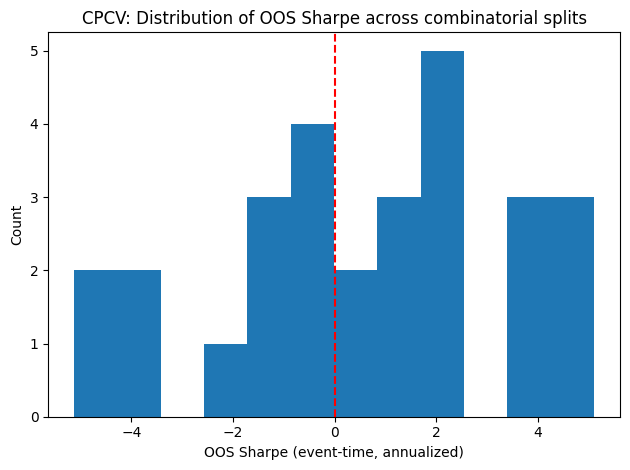

In [8]:
import itertools
import math
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def _contiguous_ranges(sorted_positions: np.ndarray):
    """Convert sorted integer positions into contiguous (start_pos, end_pos) ranges."""
    if len(sorted_positions) == 0:
        return []
    ranges = []
    start = prev = int(sorted_positions[0])
    for p in sorted_positions[1:]:
        p = int(p)
        if p == prev + 1:
            prev = p
        else:
            ranges.append((start, prev))
            start = prev = p
    ranges.append((start, prev))
    return ranges


@dataclass
class SplitInfo:
    test_group_ids: tuple
    n_test: int
    n_train_candidate: int
    n_train_final: int


def cpcv_splits(
    X: pd.DataFrame,
    t1: pd.Series,
    N: int = 8,
    k: int = 2,
    embargo_pct: float = 0.02,
    return_info: bool = False):
    """
    Yield CPCV splits (train_pos, test_pos) with purging + embargo.

    X is indexed by event start times t_{i,0} (must be monotonic increasing).
    t1 maps each start time to its event end time t_{i,1}.
    """
    if not X.index.is_monotonic_increasing:
        X = X.sort_index()

    t1 = t1.reindex(X.index)
    if t1.isna().any():
        raise ValueError("t1 contains NaNs after reindexing to X.index.")

    n = len(X)
    if N < 2 or N > n:
        raise ValueError("N must be in [2, len(X)].")
    if k < 1 or k >= N:
        raise ValueError("k must be in [1, N-1].")
    if not (0.0 <= embargo_pct < 1.0):
        raise ValueError("embargo_pct must be in [0, 1).")

    all_pos = np.arange(n)
    groups = np.array_split(all_pos, N)

    embargo_size = int(np.ceil(n * embargo_pct))
    idx = X.index

    for test_group_ids in itertools.combinations(range(N), k):
        # Test set: concatenate the chosen groups
        test_pos = np.sort(np.concatenate([groups[g] for g in test_group_ids]))
        test_set = set(test_pos.tolist())

        # Candidate train set: everything not in test
        train_pos = np.array([p for p in all_pos if p not in test_set], dtype=int)
        n_train_candidate = len(train_pos)

        # CPCV test can be fragmented -> apply purge/embargo per contiguous test interval
        test_ranges = _contiguous_ranges(test_pos)

        # Start/end times for candidate training events
        train_t0 = idx[train_pos]
        train_t1 = t1.loc[train_t0].values

        keep = np.ones(len(train_pos), dtype=bool)

        for start_p, end_p in test_ranges:
            T_start = idx[start_p]
            T_end = idx[end_p]

            # Purging: remove overlaps with the test interval [T_start, T_end]
            # Intersection condition: t0 <= T_end AND t1 >= T_start
            overlap = (train_t0 <= T_end) & (train_t1 >= T_start)
            keep &= ~overlap

            # Embargo: remove events starting right after the test interval
            if embargo_size > 0:
                emb_start_p = end_p + 1
                emb_end_p = min(end_p + embargo_size, n - 1)
                if emb_start_p <= emb_end_p:
                    emb_start_t = idx[emb_start_p]
                    emb_end_t = idx[emb_end_p]
                    embargo_hit = (train_t0 >= emb_start_t) & (train_t0 <= emb_end_t)
                    keep &= ~embargo_hit

        final_train_pos = train_pos[keep]

        if return_info:
            info = SplitInfo(
                test_group_ids=test_group_ids,
                n_test=len(test_pos),
                n_train_candidate=n_train_candidate,
                n_train_final=len(final_train_pos),
            )
            yield final_train_pos, test_pos, info
        else:
            yield final_train_pos, test_pos


def sharpe_ratio(x: np.ndarray, ann_factor: float = math.sqrt(252.0)) -> float:
    """Simple Sharpe on a vector of event-time returns, annualized by sqrt(252)."""
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size < 3:
        return float("nan")
    s = x.std(ddof=1)
    if s == 0:
        return 0.0
    return float((x.mean() / s) * ann_factor)


if __name__ == "__main__":
    rng = np.random.default_rng(7)
    # Synthetic price series with regime-like volatility
    n_days = 900
    dates = pd.date_range("2018-01-01", periods=n_days, freq="B")  # business days

    # Three regimes (low -> high -> medium) to mimic changing market conditions
    vol = np.full(n_days, 0.008)
    vol[300:520] = 0.020
    vol[520:700] = 0.012

    drift = 0.0002
    rets = drift + vol * rng.standard_normal(n_days)
    price = 100.0 * np.exp(np.cumsum(rets))
    price = pd.Series(price, index=dates, name="price")

    # Define events: start times t0 and heterogeneous end times t1
    # Random holding periods in [1, 10] business days -> overlapping labels/events
    max_h = 10
    hold = rng.integers(1, max_h + 1, size=n_days)

    # Create an event for each day except the last max_h days
    t0 = dates[:-max_h]
    t1 = pd.Series(index=t0, dtype="datetime64[ns]")
    for ts in t0:
        h = int(hold[dates.get_loc(ts)])
        end_pos = min(dates.get_loc(ts) + h, len(dates) - 1)
        t1.loc[ts] = dates[end_pos]

    # Vuild labels and features (features are lagged: no look-ahead)
    # Event return from t0 -> t1
    p0 = price.loc[t0].values
    p1 = price.reindex(t1.values).values
    event_ret_all = (p1 / p0) - 1.0

    # Binary label: 1 if positive event return, else 0
    y_all = pd.Series((event_ret_all > 0).astype(int), index=t0, name="y")

    # Features available at t0 (lagged/rolling, shifted to avoid leakage)
    r1 = price.pct_change(1)
    mom5 = price.pct_change(5)
    vol20 = r1.rolling(20).std()
    z20 = (price - price.rolling(20).mean()) / price.rolling(20).std()

    X_all = pd.DataFrame({
            "r1_lag": r1.shift(1),
            "mom5_lag": mom5.shift(1),
            "vol20_lag": vol20.shift(1),
            "z20_lag": z20.shift(1),},index=dates,)

    # Align to event starts and drop NaNs from rolling windows
    X = X_all.reindex(t0).dropna()
    y = y_all.reindex(X.index)
    t1 = t1.reindex(X.index)

    # Recompute event returns aligned to X.index
    p0 = price.loc[X.index].values
    p1 = price.reindex(t1.values).values
    event_ret = (p1 / p0) - 1.0

    print("Events after feature alignment:", len(X))

    # CPCV evaluation (purging + embargo) with a simple classifier
    N, k = 8, 2
    embargo_pct = 0.02

    model = Pipeline(
        steps=[("scaler", StandardScaler()),
         ("clf", LogisticRegression(max_iter=2000, solver="lbfgs")),])

    sharpes = []

    for split_id, (train_pos, test_pos, info) in enumerate(
        cpcv_splits(X, t1, N=N, k=k, embargo_pct=embargo_pct, return_info=True)):
        X_train = X.iloc[train_pos]
        y_train = y.iloc[train_pos]
        X_test = X.iloc[test_pos]

        model.fit(X_train, y_train)
        p_up = model.predict_proba(X_test)[:, 1]

        # Simple trading rule from probabilities
        sig = np.where(p_up > 0.55, 1, np.where(p_up < 0.45, -1, 0))

        # Event-time PnL approximation (illustration)
        r_test = sig * event_ret[test_pos]
        sr = sharpe_ratio(r_test)
        sharpes.append(sr)

        if split_id == 0:
            print("\nFirst CPCV split (diagnostic)")
            print("  Test groups:", info.test_group_ids)
            print("  Candidate train size:", info.n_train_candidate)
            print("  Final train size (after purge/embargo):", info.n_train_final)
            for a, b in _contiguous_ranges(np.sort(test_pos)):
                print("  Test interval:", X.index[a].date(), "->", X.index[b].date())

    sharpes = np.asarray(sharpes, dtype=float)

    # Summarize the OOS distribution
    print("\nCPCV summary")
    print(f"  Number of splits = C({N},{k}) = {len(sharpes)}")
    print(f"  Mean Sharpe:   {np.nanmean(sharpes):.3f}")
    print(f"  Median Sharpe: {np.nanmedian(sharpes):.3f}")
    print(f"  5% quantile:   {np.nanquantile(sharpes, 0.05):.3f}")
    print(f"  Failure P(Sharpe<0): {np.mean(sharpes < 0):.3%}")

    # Visualize the OOS Sharpe distribution
    plt.figure()
    plt.hist(sharpes[np.isfinite(sharpes)], bins=12)
    plt.axvline(0.0, linestyle="--", c='r')
    plt.title("CPCV: Distribution of OOS Sharpe across combinatorial splits")
    plt.xlabel("OOS Sharpe (event-time, annualized)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


WFA

WFA summary
  OOS Annualized Return: 1.080%
  OOS Sharpe:            0.148
  OOS Max Drawdown:      -21.069%
  Global IS best C:      0.01
  Global IS Ann. Return: 15.714%
  Walk-Forward Efficiency (WFE): 0.069


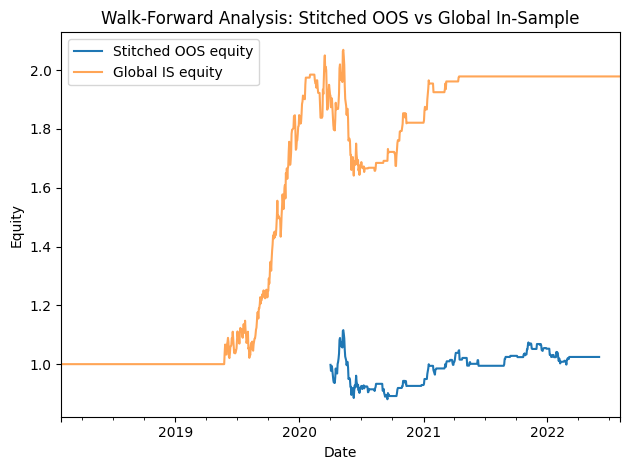

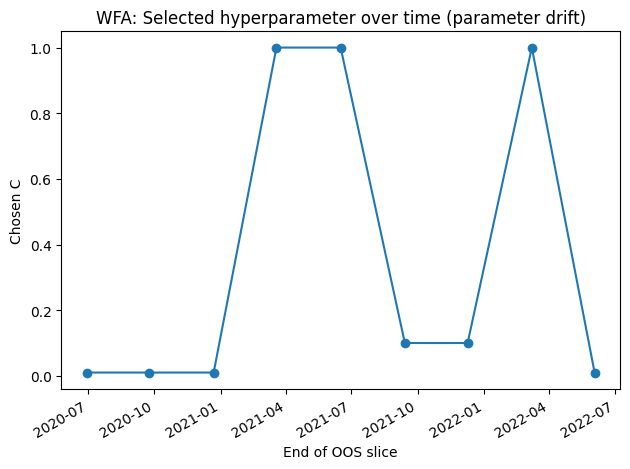

In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def ann_return(returns: pd.Series, periods_per_year: int = 252) -> float:
    """Annualized geometric return from periodic returns."""
    r = returns.dropna().astype(float)
    if len(r) == 0:
        return float("nan")
    equity = (1.0 + r).prod()
    years = len(r) / periods_per_year
    if years <= 0:
        return float("nan")
    return float(equity ** (1.0 / years) - 1.0)


def sharpe(returns: pd.Series, periods_per_year: int = 252) -> float:
    """Annualized Sharpe ratio (no risk-free rate)."""
    r = returns.dropna().astype(float)
    if len(r) < 3:
        return float("nan")
    s = r.std(ddof=1)
    if s == 0:
        return 0.0
    return float((r.mean() / s) * math.sqrt(periods_per_year))


def max_drawdown(equity: pd.Series) -> float:
    """Max drawdown of an equity curve (equity indexed by time)."""
    e = equity.dropna().astype(float)
    if len(e) == 0:
        return float("nan")
    peak = e.cummax()
    dd = e / peak - 1.0
    return float(dd.min())


def make_synthetic_price(n_days: int = 1200, seed: int = 7) -> pd.Series:
    """Synthetic price series with regime-like volatility."""
    rng = np.random.default_rng(seed)
    dates = pd.date_range("2018-01-01", periods=n_days, freq="B")

    vol = np.full(n_days, 0.008)
    vol[350:650] = 0.020
    vol[650:900] = 0.012

    drift = 0.0002
    rets = drift + vol * rng.standard_normal(n_days)
    price = 100.0 * np.exp(np.cumsum(rets))
    return pd.Series(price, index=dates, name="price")


def make_features(price: pd.Series) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    """Create lagged features X_t, label y_t = sign(r_{t+1}), and next-day return r_{t+1}."""
    r1 = price.pct_change(1)
    mom5 = price.pct_change(5)
    vol20 = r1.rolling(20).std()
    z20 = (price - price.rolling(20).mean()) / price.rolling(20).std()

    X = pd.DataFrame(
        {
            "r1_lag": r1.shift(1),
            "mom5_lag": mom5.shift(1),
            "vol20_lag": vol20.shift(1),
            "z20_lag": z20.shift(1),
        },
        index=price.index,
    )

    # Predict next-day direction
    y = (r1.shift(-1) > 0).astype(int)
    r_next = r1.shift(-1)

    df = pd.concat([X, y.rename("y"), r_next.rename("r_next")], axis=1).dropna()
    X = df[["r1_lag", "mom5_lag", "vol20_lag", "z20_lag"]]
    y = df["y"].astype(int)
    r_next = df["r_next"].astype(float)
    return X, y, r_next


def positions_from_proba(p_up: np.ndarray, long_th: float = 0.55, short_th: float = 0.45) -> np.ndarray:
    """Map class probabilities to positions: long / short / flat."""
    return np.where(p_up > long_th, 1, np.where(p_up < short_th, -1, 0))


def run_wfa(
    X: pd.DataFrame,
    y: pd.Series,
    r_next: pd.Series,
    train_len: int = 504,     # ~2y
    val_len: int = 63,        # ~1q
    test_len: int = 63,       # ~1q
    step: int = 63,
    C_grid: list[float] | None = None,
    window: str = "sliding",  # "sliding" or "expanding"
):
    """Walk-forward analysis with explicit train/val/test segmentation and hyperparameter tracking."""
    if C_grid is None:
        C_grid = [0.01, 0.1, 1.0, 10.0]

    n = len(X)
    if not (len(y) == n and len(r_next) == n):
        raise ValueError("X, y, and r_next must have the same length after alignment.")

    model = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, solver="lbfgs")),
        ]
    )

    oos_returns = []          # list of pd.Series slices
    chosen_C = []             # (timestamp, C)

    i = 0
    while True:
        if window == "expanding":
            train_start = 0
            train_end = train_len + i * step
        else:
            train_start = i * step
            train_end = train_start + train_len

        val_start = train_end
        val_end = val_start + val_len
        test_start = val_end
        test_end = test_start + test_len

        if test_end > n:
            break

        X_train = X.iloc[train_start:train_end]
        y_train = y.iloc[train_start:train_end]

        X_val = X.iloc[val_start:val_end]
        r_val = r_next.iloc[val_start:val_end]

        X_test = X.iloc[test_start:test_end]
        r_test_next = r_next.iloc[test_start:test_end]

        # ----------------------------
        # Hyperparameter tuning (ONLY on validation slice)
        # ----------------------------
        best_C = None
        best_score = -np.inf

        for C in C_grid:
            model.set_params(clf__C=C)
            model.fit(X_train, y_train)

            p_val = model.predict_proba(X_val)[:, 1]
            pos_val = positions_from_proba(p_val)
            pnl_val = pd.Series(pos_val, index=X_val.index) * r_val

            score = sharpe(pnl_val)
            if np.isfinite(score) and score > best_score:
                best_score = score
                best_C = C

        if best_C is None:
            best_C = C_grid[0]

        # ----------------------------
        # Freeze hyperparameter and refit on (train + val), then test OOS
        # ----------------------------
        model.set_params(clf__C=best_C)
        X_trainval = X.iloc[train_start:val_end]
        y_trainval = y.iloc[train_start:val_end]
        model.fit(X_trainval, y_trainval)

        p_test = model.predict_proba(X_test)[:, 1]
        pos_test = positions_from_proba(p_test)
        pnl_test = pd.Series(pos_test, index=X_test.index) * r_test_next

        oos_returns.append(pnl_test)
        chosen_C.append((X_test.index[-1], best_C))

        i += 1

    oos = pd.concat(oos_returns).sort_index()
    equity = (1.0 + oos).cumprod()
    C_path = pd.Series({t: c for t, c in chosen_C}).sort_index()

    return oos, equity, C_path


def global_in_sample_best(
    X: pd.DataFrame,
    y: pd.Series,
    r_next: pd.Series,
    C_grid: list[float],
):
    """Hindsight (global in-sample) optimization: choose C maximizing in-sample Sharpe."""
    model = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, solver="lbfgs")),
        ]
    )

    best_C, best_sr = None, -np.inf
    best_ret = None

    for C in C_grid:
        model.set_params(clf__C=C)
        model.fit(X, y)
        p = model.predict_proba(X)[:, 1]
        pos = positions_from_proba(p)
        pnl = pd.Series(pos, index=X.index) * r_next
        sr = sharpe(pnl)
        if np.isfinite(sr) and sr > best_sr:
            best_sr = sr
            best_C = C
            best_ret = pnl

    return best_C, best_ret


if __name__ == "__main__":
    # ------------------------------------------------------------
    # 1) Data
    # ------------------------------------------------------------
    price = make_synthetic_price(n_days=1200, seed=7)
    X, y, r_next = make_features(price)

    # ------------------------------------------------------------
    # 2) Walk-forward analysis (sliding window)
    # ------------------------------------------------------------
    C_grid = [0.01, 0.1, 1.0, 10.0]
    oos, equity_oos, C_path = run_wfa(
        X, y, r_next,
        train_len=504, val_len=63, test_len=63, step=63,
        C_grid=C_grid,
        window="sliding",
    )

    # ------------------------------------------------------------
    # 3) Global in-sample (hindsight) benchmark and WFE
    # ------------------------------------------------------------
    best_C_is, is_returns = global_in_sample_best(X, y, r_next, C_grid=C_grid)
    equity_is = (1.0 + is_returns).cumprod()

    ar_oos = ann_return(oos)
    ar_is = ann_return(is_returns)
    wfe = float(ar_oos / ar_is) if np.isfinite(ar_oos) and np.isfinite(ar_is) and ar_is != 0 else float("nan")

    print("WFA summary")
    print(f"  OOS Annualized Return: {ar_oos:.3%}")
    print(f"  OOS Sharpe:            {sharpe(oos):.3f}")
    print(f"  OOS Max Drawdown:      {max_drawdown(equity_oos):.3%}")
    print(f"  Global IS best C:      {best_C_is}")
    print(f"  Global IS Ann. Return: {ar_is:.3%}")
    print(f"  Walk-Forward Efficiency (WFE): {wfe:.3f}")

    # ------------------------------------------------------------
    # 4) Diagnostics: stitched equity curve and parameter drift
    # ------------------------------------------------------------
    plt.figure()
    equity_oos.plot(label="Stitched OOS equity")
    equity_is.plot(label="Global IS equity", alpha=0.7)
    plt.title("Walk-Forward Analysis: Stitched OOS vs Global In-Sample")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    C_path.plot(marker="o")
    plt.title("WFA: Selected hyperparameter over time (parameter drift)")
    plt.xlabel("End of OOS slice")
    plt.ylabel("Chosen C")
    plt.tight_layout()
    plt.show()